In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## iCESM Pi Control TAGGED 
## print upper, lower, difference of precipitation weighted and unweighted d18O from each ocean tag to the record at the WDC location
## vs. PSA1 Quartiles (Upper, Lower, and Difference Panels)
### RAW - Meaning that the seasonal cycle is not removed nor are the variables detrended. (Other Notebooks will explore variations of this)
### there's some extra code sections in here from an earlier version from this script where I looked at d18O of water vapor and things



In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_for_Drafts_08May2019'

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')
print(CTRL_DATA)

CTRL_DATA_PATH2 = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA2 = xr.open_dataset(CTRL_DATA_PATH2+'/CTRL_DATA_TAGGED_VAPOR.nc')
print(CTRL_DATA2)

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    tp            (time, lat, lon) float32 ...
    ci            (time, lat, lon) float32 ...
    d18O          (time, lat, lon) float32 ...
    d18O_Atl_05   (time, lat, lon) float32 ...
    d18O_Atl_15   (time, lat, lon) float32 ...
    d18O_Atl_25   (time, lat, lon) float32 ...
    d18O_Atl_35   (time, lat, lon) float32 ...
    d18O_Atl_45   (time, lat, lon) float32 ...
    d18O_

In [4]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

d18O_V_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V'] #per mill
total_prec_water = CTRL_DATA2.data_vars['H2OV_total_prec_water'] #mm

In [5]:
#sst_tmon_ctrl

In [6]:
#Open pandas dfs of all indices and ASL information
pdo_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_tmon.pkl')
# pdo_index_ctrl.head(n=5)
pdo_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_seas.pkl')
# pdo_seas_mean_index_ctrl.head(n=5)
pdo_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_ann_mean.pkl')
# pdo_ann_mean_index_ctrl.head(n=5)

soi_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_tmon.pkl')
# soi_index_ctrl.head(n=5)
soi_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_seas.pkl')
# soi_seas_mean_index_ctrl.head(n=5)
soi_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_ann_mean.pkl')
# soi_ann_mean_index_ctrl.head(n=5)
soi_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_12roll_mean.pkl')
# soi_12roll_mean_index_ctrl.head(n=10)
soi_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_6roll_mean.pkl')
# soi_6roll_mean_index_ctrl.head(n=5)
soi_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_3roll_mean.pkl')
# soi_3roll_mean_index_ctrl.head(n=5)
soi_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_band_filt.pkl')
# soi_band_filt_index_ctrl.head(n=5)

nino34_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_tmon.pkl')
# nino34_index_ctrl.head(n=5)
nino34_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_seas.pkl')
# nino34_seas_mean_index_ctrl.head(n=5)
nino34_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_ann_mean.pkl')
# nino34_ann_mean_index_ctrl.head(n=5)
nino34_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_12roll_mean.pkl')
# nino34_12roll_mean_index_ctrl.head(n=10)
nino34_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_6roll_mean.pkl')
# nino34_6roll_mean_index_ctrl.head(n=5)
nino34_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_3roll_mean.pkl')
# nino34_3roll_mean_index_ctrl.head(n=5)
nino34_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_band_filt.pkl')
# nino34_band_filt_index_ctrl.head(n=5)

enso_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_tmon.pkl')
# enso_indices_ctrl.head(n=5)
enso_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_seas.pkl')
# enso_seas_mean_indices_ctrl.head(n=5)
enso_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_ann_mean.pkl')
# enso_ann_mean_indices_ctrl.head(n=5)
enso_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_ctrl.head(n=10)
enso_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_ctrl.head(n=5)
enso_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_ctrl.head(n=5)
enso_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_band_filt.pkl')
# enso_band_filt_indices_ctrl.head(n=5)

SAM_PSAs_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_tmon.pkl')
# SAM_PSAs_indices_ctrl.head(n=5)
SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_ctrl.head(n=5)
SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))
SAM_PSAs_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_ctrl.head(n=10)
SAM_PSAs_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_ctrl.head(n=5)

df_d18O_psuedoWDC_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_tmon.pkl')
# df_d18O_psuedoWDC_tmon_ctrl.head(n=5)
d18O_psuedoWDC_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_seas.pkl')
# d18O_psuedoWDC_seas_mean_ctrl.head(n=5)
d18O_psuedoWDC_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_ann_mean.pkl')
# d18O_psuedoWDC_ann_mean_ctrl.head(n=5)
d18O_psuedoWDC_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_12roll_mean.pkl')
# d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)
d18O_psuedoWDC_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_6roll_mean.pkl')
# d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_3roll_mean.pkl')
# d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_band_filt.pkl')
# d18O_psuedoWDC_band_filt_ctrl.head(n=5)

# df_d18O_psuedowestcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_ctrl.head(n=5)
# d18O_psuedowestcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_ctrl.head(n=5)
# d18O_psuedowestcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_ctrl.head(n=5)
# d18O_psuedowestcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedowestcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_ctrl.head(n=5)

# df_d18O_psuedoeastcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)
# d18O_psuedoeastcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedoeastcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_ctrl.head(n=5)

# d18O_wais_pcs_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_ctrl.head(n=5)
# d18O_wais_pcs_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_ctrl.head(n=5)
# d18O_wais_pcs_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_ctrl.head(n=5)
# d18O_wais_pcs_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_ctrl.head(n=12)
# d18O_wais_pcs_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_ctrl.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Rel_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_ctrl.head(n=5)
# Rel_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_ctrl.head(n=5)
# Rel_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_ctrl.head(n=10)
# Rel_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_ctrl.head(n=5)
# Rel_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_ctrl.head(n=5)
# Rel_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_ctrl.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Abs_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_ctrl.head(n=5)
# Abs_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_ctrl.head(n=5)
# Abs_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_ctrl.head(n=10)
# Abs_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_ctrl.head(n=5)
# Abs_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_ctrl.head(n=5)
# Abs_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_ctrl.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_ctrl_tagged_df.head(n=5)
Rel_CP_djf_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)
Rel_CP_mam_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_ctrl.head(n=5)
Rel_CP_jja_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_ctrl.head(n=5)
Rel_CP_son_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_ctrl.head(n=5)
Rel_CP_ann_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_ctrl.head(n=5))
Rel_CP_12roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_12roll_mean.pkl')
# Rel_CP_12roll_mean_indices_raw_ctrl.head(n=10)
Rel_CP_6roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_6roll_mean.pkl')
# Rel_CP_6roll_mean_indices_raw_ctrl.head(n=5)
Rel_CP_3roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)
# Rel_CP_band_filt_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_ctrl.head(n=5)


                 SAM      PSA1      PSA2
time                                    
1702-01-01 -0.311936 -0.015404  0.094802
1703-01-01 -0.819279  0.553104  0.060246
1704-01-01 -0.714730  0.496267 -0.208190
1705-01-01 -0.431827  0.106548 -0.660348
1706-01-01  0.391807 -0.572466  0.115213
                vals       lats   lons  sectormean  indice
time                                                      
1702-01-01 -5.477830 -71.052632  197.5  986.772813       0
1703-01-01 -5.095673 -71.052632  195.0  989.296173       1
1704-01-01 -4.715917 -71.052632  205.0  989.053075       2
1705-01-01 -7.214285 -71.052632  205.0  987.087820       3
1706-01-01 -6.000570 -71.052632  207.5  982.878988       4


## Creating the Tagged Regions and Weighting the d18O contribution by the amount of precip
### see after for d18O VAPOR

In [7]:
#Tagged Variables in right units
d18O_Atl_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_05'] #per mill
d18O_Atl_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_15'] #per mill
d18O_Atl_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_25'] #per mill
d18O_Atl_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_35'] #per mill
d18O_Atl_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_45'] #per mill
d18O_Atl_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_55'] #per mill
d18O_Atl_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_65'] #per mill
d18O_Atl_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_75'] #per mill
tp_Atl_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_05']*60*60*24*1000  #in mm/day  
tp_Atl_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_15']*60*60*24*1000  #in mm/day  
tp_Atl_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_25']*60*60*24*1000  #in mm/day  
tp_Atl_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_35']*60*60*24*1000  #in mm/day  
tp_Atl_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_45']*60*60*24*1000  #in mm/day  
tp_Atl_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_55']*60*60*24*1000  #in mm/day  
tp_Atl_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_65']*60*60*24*1000  #in mm/day  
tp_Atl_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_75']*60*60*24*1000  #in mm/day  
d18O_Pac_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_05'] #per mill
d18O_Pac_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_15'] #per mill
d18O_Pac_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_25'] #per mill
d18O_Pac_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_35'] #per mill
d18O_Pac_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_45'] #per mill
d18O_Pac_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_55'] #per mill
d18O_Pac_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_65'] #per mill
d18O_Pac_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_75'] #per mill
tp_Pac_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_05']*60*60*24*1000  #in mm/day  
tp_Pac_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_15']*60*60*24*1000  #in mm/day  
tp_Pac_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_25']*60*60*24*1000  #in mm/day  
tp_Pac_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_35']*60*60*24*1000  #in mm/day  
tp_Pac_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_45']*60*60*24*1000  #in mm/day  
tp_Pac_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_55']*60*60*24*1000  #in mm/day  
tp_Pac_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_65']*60*60*24*1000  #in mm/day  
tp_Pac_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_75']*60*60*24*1000  #in mm/day  
d18O_Ind_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_05'] #per mill
d18O_Ind_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_15'] #per mill
d18O_Ind_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_25'] #per mill
d18O_Ind_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_35'] #per mill
d18O_Ind_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_45'] #per mill
d18O_Ind_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_55'] #per mill
d18O_Ind_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_65'] #per mill
d18O_Ind_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_75'] #per mill
tp_Ind_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_05']*60*60*24*1000  #in mm/day  
tp_Ind_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_15']*60*60*24*1000  #in mm/day  
tp_Ind_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_25']*60*60*24*1000  #in mm/day  
tp_Ind_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_35']*60*60*24*1000  #in mm/day  
tp_Ind_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_45']*60*60*24*1000  #in mm/day  
tp_Ind_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_55']*60*60*24*1000  #in mm/day  
tp_Ind_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_65']*60*60*24*1000  #in mm/day  
tp_Ind_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_75']*60*60*24*1000  #in mm/day  
d18O_AA_ice_tmon_ctrl = CTRL_DATA.data_vars['d18O_AA_ice'] #per mill
d18O_AA_land_tmon_ctrl = CTRL_DATA.data_vars['d18O_AA_land'] #per mill
tp_AA_ice_tmon_ctrl = CTRL_DATA.data_vars['tp_AA_ice']*60*60*24*1000  #in mm/day  
tp_AA_land_tmon_ctrl = CTRL_DATA.data_vars['tp_AA_land']*60*60*24*1000  #in mm/day  

In [8]:
#Weight d18O signal by precipitation from tagged region w.r.t. total precipition
#Atlantic weighted d18O
d18O_Atl_05_weighted_tmon_ctrl = d18O_Atl_05_tmon_ctrl*(tp_Atl_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_15_weighted_tmon_ctrl = d18O_Atl_15_tmon_ctrl*(tp_Atl_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_25_weighted_tmon_ctrl = d18O_Atl_25_tmon_ctrl*(tp_Atl_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_35_weighted_tmon_ctrl = d18O_Atl_35_tmon_ctrl*(tp_Atl_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_45_weighted_tmon_ctrl = d18O_Atl_45_tmon_ctrl*(tp_Atl_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_55_weighted_tmon_ctrl = d18O_Atl_55_tmon_ctrl*(tp_Atl_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_65_weighted_tmon_ctrl = d18O_Atl_65_tmon_ctrl*(tp_Atl_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_75_weighted_tmon_ctrl = d18O_Atl_75_tmon_ctrl*(tp_Atl_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Pacific weighted d18O
d18O_Pac_05_weighted_tmon_ctrl = d18O_Pac_05_tmon_ctrl*(tp_Pac_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_15_weighted_tmon_ctrl = d18O_Pac_15_tmon_ctrl*(tp_Pac_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_25_weighted_tmon_ctrl = d18O_Pac_25_tmon_ctrl*(tp_Pac_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_35_weighted_tmon_ctrl = d18O_Pac_35_tmon_ctrl*(tp_Pac_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_45_weighted_tmon_ctrl = d18O_Pac_45_tmon_ctrl*(tp_Pac_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_55_weighted_tmon_ctrl = d18O_Pac_55_tmon_ctrl*(tp_Pac_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_65_weighted_tmon_ctrl = d18O_Pac_65_tmon_ctrl*(tp_Pac_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_75_weighted_tmon_ctrl = d18O_Pac_75_tmon_ctrl*(tp_Pac_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Indian weighted d18O
d18O_Ind_05_weighted_tmon_ctrl = d18O_Ind_05_tmon_ctrl*(tp_Ind_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_15_weighted_tmon_ctrl = d18O_Ind_15_tmon_ctrl*(tp_Ind_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_25_weighted_tmon_ctrl = d18O_Ind_25_tmon_ctrl*(tp_Ind_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_35_weighted_tmon_ctrl = d18O_Ind_35_tmon_ctrl*(tp_Ind_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_45_weighted_tmon_ctrl = d18O_Ind_45_tmon_ctrl*(tp_Ind_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_55_weighted_tmon_ctrl = d18O_Ind_55_tmon_ctrl*(tp_Ind_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_65_weighted_tmon_ctrl = d18O_Ind_65_tmon_ctrl*(tp_Ind_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_75_weighted_tmon_ctrl = d18O_Ind_75_tmon_ctrl*(tp_Ind_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Antarctic weighted d18O
d18O_AA_ice_weighted_tmon_ctrl = d18O_AA_ice_tmon_ctrl*(tp_AA_ice_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_AA_land_weighted_tmon_ctrl = d18O_AA_land_tmon_ctrl*(tp_AA_land_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Therefore, I expect that after weight the d18O signal by the amount of precip, the sum of the basin d18O should look like the total d18O

In [9]:
#Unweighted d18O signal by precipitation from tagged region w.r.t. total precipition
#Atlantic unweighted d18O
d18O_Atl_05_unweighted_tmon_ctrl = d18O_Atl_05_tmon_ctrl  #per mill
d18O_Atl_15_unweighted_tmon_ctrl = d18O_Atl_15_tmon_ctrl  #per mill
d18O_Atl_25_unweighted_tmon_ctrl = d18O_Atl_25_tmon_ctrl  #per mill
d18O_Atl_35_unweighted_tmon_ctrl = d18O_Atl_35_tmon_ctrl  #per mill
d18O_Atl_45_unweighted_tmon_ctrl = d18O_Atl_45_tmon_ctrl  #per mill
d18O_Atl_55_unweighted_tmon_ctrl = d18O_Atl_55_tmon_ctrl  #per mill
d18O_Atl_65_unweighted_tmon_ctrl = d18O_Atl_65_tmon_ctrl  #per mill
d18O_Atl_75_unweighted_tmon_ctrl = d18O_Atl_75_tmon_ctrl  #per mill

#Pacific unweighted d18O
d18O_Pac_05_unweighted_tmon_ctrl = d18O_Pac_05_tmon_ctrl  #per mill
d18O_Pac_15_unweighted_tmon_ctrl = d18O_Pac_15_tmon_ctrl  #per mill
d18O_Pac_25_unweighted_tmon_ctrl = d18O_Pac_25_tmon_ctrl  #per mill
d18O_Pac_35_unweighted_tmon_ctrl = d18O_Pac_35_tmon_ctrl  #per mill
d18O_Pac_45_unweighted_tmon_ctrl = d18O_Pac_45_tmon_ctrl  #per mill
d18O_Pac_55_unweighted_tmon_ctrl = d18O_Pac_55_tmon_ctrl  #per mill
d18O_Pac_65_unweighted_tmon_ctrl = d18O_Pac_65_tmon_ctrl  #per mill
d18O_Pac_75_unweighted_tmon_ctrl = d18O_Pac_75_tmon_ctrl  #per mill

#Indian unweighted d18O
d18O_Ind_05_unweighted_tmon_ctrl = d18O_Ind_05_tmon_ctrl  #per mill
d18O_Ind_15_unweighted_tmon_ctrl = d18O_Ind_15_tmon_ctrl  #per mill
d18O_Ind_25_unweighted_tmon_ctrl = d18O_Ind_25_tmon_ctrl  #per mill
d18O_Ind_35_unweighted_tmon_ctrl = d18O_Ind_35_tmon_ctrl  #per mill
d18O_Ind_45_unweighted_tmon_ctrl = d18O_Ind_45_tmon_ctrl  #per mill
d18O_Ind_55_unweighted_tmon_ctrl = d18O_Ind_55_tmon_ctrl  #per mill
d18O_Ind_65_unweighted_tmon_ctrl = d18O_Ind_65_tmon_ctrl  #per mill
d18O_Ind_75_unweighted_tmon_ctrl = d18O_Ind_75_tmon_ctrl  #per mill

#Antarctic unweighted d18O
d18O_AA_ice_unweighted_tmon_ctrl = d18O_AA_ice_tmon_ctrl  #per mill
d18O_AA_land_unweighted_tmon_ctrl = d18O_AA_land_tmon_ctrl  #per mill

#Therefore, I expect that after weight the d18O signal by the amount of precip, the sum of the basin d18O should look like the total d18O

### Combining tags into 30 degree lat bands, still seperated by ocean basin.  Also, keeping AA ice and land seperate, not sure of their exact definition
### Have variables of total precipitation that originated in that sector, and (weighted by precip) d18O signal originating in that sector.  Can compare this to total precipitation and total d18O; particularly want to compare to total d18O over AA and at WDC location

In [10]:
#Included unweighted d18O of precip results; may need it?

In [11]:
# #Atlantic 20 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
# tp_Atl_05_tmon_ctrl = (tp_Atl_25_tmon_ctrl+tp_Atl_35_tmon_ctrl)
# tp_Atl_15_tmon_ctrl = (tp_Atl_45_tmon_ctrl+tp_Atl_55_tmon_ctrl)
# tp_Atl_25_tmon_ctrl = (tp_Atl_65_tmon_ctrl+tp_Atl_75_tmon_ctrl)

# d18O_Atl_05_weighted_tmon_ctrl = (d18O_Atl_25_weighted_tmon_ctrl+d18O_Atl_35_weighted_tmon_ctrl)
# d18O_Atl_15_weighted_tmon_ctrl = (d18O_Atl_45_weighted_tmon_ctrl+d18O_Atl_55_weighted_tmon_ctrl)
# d18O_Atl_25_weighted_tmon_ctrl = (d18O_Atl_65_weighted_tmon_ctrl+d18O_Atl_75_weighted_tmon_ctrl)

# d18O_Atl_05_unweighted_tmon_ctrl = (d18O_Atl_25_tmon_ctrl+d18O_Atl_35_tmon_ctrl)
# d18O_Atl_15_unweighted_tmon_ctrl = (d18O_Atl_45_tmon_ctrl+d18O_Atl_55_tmon_ctrl)
# d18O_Atl_25_unweighted_tmon_ctrl = (d18O_Atl_65_tmon_ctrl+d18O_Atl_75_tmon_ctrl)

# #Pacific 20 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
# tp_Pac_05_tmon_ctrl = (tp_Pac_25_tmon_ctrl+tp_Pac_35_tmon_ctrl)
# tp_Pac_15_tmon_ctrl = (tp_Pac_45_tmon_ctrl+tp_Pac_55_tmon_ctrl)
# tp_Pac_25_tmon_ctrl = (tp_Pac_65_tmon_ctrl+tp_Pac_75_tmon_ctrl)

# d18O_Pac_05_weighted_tmon_ctrl = (d18O_Pac_25_weighted_tmon_ctrl+d18O_Pac_35_weighted_tmon_ctrl)
# d18O_Pac_15_weighted_tmon_ctrl = (d18O_Pac_45_weighted_tmon_ctrl+d18O_Pac_55_weighted_tmon_ctrl)
# d18O_Pac_25_weighted_tmon_ctrl = (d18O_Pac_65_weighted_tmon_ctrl+d18O_Pac_75_weighted_tmon_ctrl)

# d18O_Pac_05_unweighted_tmon_ctrl = (d18O_Pac_25_tmon_ctrl+d18O_Pac_35_tmon_ctrl)
# d18O_Pac_15_unweighted_tmon_ctrl = (d18O_Pac_45_tmon_ctrl+d18O_Pac_55_tmon_ctrl)
# d18O_Pac_25_unweighted_tmon_ctrl = (d18O_Pac_65_tmon_ctrl+d18O_Pac_75_tmon_ctrl)

# #Indian 20 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
# tp_Ind_05_tmon_ctrl = (tp_Ind_25_tmon_ctrl+tp_Ind_35_tmon_ctrl)
# tp_Ind_15_tmon_ctrl = (tp_Ind_45_tmon_ctrl+tp_Ind_55_tmon_ctrl)
# tp_Ind_25_tmon_ctrl = (tp_Ind_65_tmon_ctrl+tp_Ind_75_tmon_ctrl)

# d18O_Ind_05_weighted_tmon_ctrl = (d18O_Ind_25_weighted_tmon_ctrl+d18O_Ind_35_weighted_tmon_ctrl)
# d18O_Ind_15_weighted_tmon_ctrl = (d18O_Ind_45_weighted_tmon_ctrl+d18O_Ind_55_weighted_tmon_ctrl)
# d18O_Ind_25_weighted_tmon_ctrl = (d18O_Ind_65_weighted_tmon_ctrl+d18O_Ind_75_weighted_tmon_ctrl)

# d18O_Ind_05_unweighted_tmon_ctrl = (d18O_Ind_25_tmon_ctrl+d18O_Ind_35_tmon_ctrl)
# d18O_Ind_15_unweighted_tmon_ctrl = (d18O_Ind_45_tmon_ctrl+d18O_Ind_55_tmon_ctrl)
# d18O_Ind_25_unweighted_tmon_ctrl = (d18O_Ind_65_tmon_ctrl+d18O_Ind_75_tmon_ctrl)

# #Antarctic Land sector, just use these variables that were already created:
# # tp_AA_land_tmon_ctrl
# # d18O_AA_land_weighted_tmon_ctrl
# # d18O_AA_land_tmon_ctrl

# # tp_AA_ice_tmon_ctrl
# # d18O_AA_ice_weighted_tmon_ctrl
# # d18O_AA_ice_tmon_ctrl

## Define d18O of WATER VAPOR and Total Precipitable Water for each Tagged Region 

In [12]:
#Tagged d18O VAPOR Variables in right units
d18O_V_Atl_05_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_05'] #per mill
d18O_V_Atl_15_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_15'] #per mill
d18O_V_Atl_25_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_25'] #per mill
d18O_V_Atl_35_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_35'] #per mill
d18O_V_Atl_45_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_45'] #per mill
d18O_V_Atl_55_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_55'] #per mill
d18O_V_Atl_65_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_65'] #per mill
d18O_V_Atl_75_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Atl_75'] #per mill

tpw_Atl_05_tmon_ctrl = CTRL_DATA2.data_vars['Atl_05_H2OV_total_prec_water'] #in mm  
tpw_Atl_15_tmon_ctrl = CTRL_DATA2.data_vars['Atl_15_H2OV_total_prec_water'] #in mm 
tpw_Atl_25_tmon_ctrl = CTRL_DATA2.data_vars['Atl_25_H2OV_total_prec_water'] #in mm  
tpw_Atl_35_tmon_ctrl = CTRL_DATA2.data_vars['Atl_35_H2OV_total_prec_water'] #in mm  
tpw_Atl_45_tmon_ctrl = CTRL_DATA2.data_vars['Atl_45_H2OV_total_prec_water'] #in mm  
tpw_Atl_55_tmon_ctrl = CTRL_DATA2.data_vars['Atl_55_H2OV_total_prec_water'] #in mm  
tpw_Atl_65_tmon_ctrl = CTRL_DATA2.data_vars['Atl_65_H2OV_total_prec_water'] #in mm  
tpw_Atl_75_tmon_ctrl = CTRL_DATA2.data_vars['Atl_75_H2OV_total_prec_water'] #in mm  


d18O_V_Pac_05_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_05'] #per mill
d18O_V_Pac_15_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_15'] #per mill
d18O_V_Pac_25_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_25'] #per mill
d18O_V_Pac_35_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_35'] #per mill
d18O_V_Pac_45_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_45'] #per mill
d18O_V_Pac_55_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_55'] #per mill
d18O_V_Pac_65_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_65'] #per mill
d18O_V_Pac_75_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Pac_75'] #per mill

tpw_Pac_05_tmon_ctrl = CTRL_DATA2.data_vars['Pac_05_H2OV_total_prec_water'] #in mm  
tpw_Pac_15_tmon_ctrl = CTRL_DATA2.data_vars['Pac_15_H2OV_total_prec_water'] #in mm 
tpw_Pac_25_tmon_ctrl = CTRL_DATA2.data_vars['Pac_25_H2OV_total_prec_water'] #in mm  
tpw_Pac_35_tmon_ctrl = CTRL_DATA2.data_vars['Pac_35_H2OV_total_prec_water'] #in mm  
tpw_Pac_45_tmon_ctrl = CTRL_DATA2.data_vars['Pac_45_H2OV_total_prec_water'] #in mm  
tpw_Pac_55_tmon_ctrl = CTRL_DATA2.data_vars['Pac_55_H2OV_total_prec_water'] #in mm  
tpw_Pac_65_tmon_ctrl = CTRL_DATA2.data_vars['Pac_65_H2OV_total_prec_water'] #in mm  
tpw_Pac_75_tmon_ctrl = CTRL_DATA2.data_vars['Pac_75_H2OV_total_prec_water'] #in mm  


d18O_V_Ind_05_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_05'] #per mill
d18O_V_Ind_15_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_15'] #per mill
d18O_V_Ind_25_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_25'] #per mill
d18O_V_Ind_35_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_35'] #per mill
d18O_V_Ind_45_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_45'] #per mill
d18O_V_Ind_55_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_55'] #per mill
d18O_V_Ind_65_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_65'] #per mill
d18O_V_Ind_75_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_Ind_75'] #per mill

tpw_Ind_05_tmon_ctrl = CTRL_DATA2.data_vars['Ind_05_H2OV_total_prec_water'] #in mm  
tpw_Ind_15_tmon_ctrl = CTRL_DATA2.data_vars['Ind_15_H2OV_total_prec_water'] #in mm 
tpw_Ind_25_tmon_ctrl = CTRL_DATA2.data_vars['Ind_25_H2OV_total_prec_water'] #in mm  
tpw_Ind_35_tmon_ctrl = CTRL_DATA2.data_vars['Ind_35_H2OV_total_prec_water'] #in mm  
tpw_Ind_45_tmon_ctrl = CTRL_DATA2.data_vars['Ind_45_H2OV_total_prec_water'] #in mm  
tpw_Ind_55_tmon_ctrl = CTRL_DATA2.data_vars['Ind_55_H2OV_total_prec_water'] #in mm  
tpw_Ind_65_tmon_ctrl = CTRL_DATA2.data_vars['Ind_65_H2OV_total_prec_water'] #in mm  
tpw_Ind_75_tmon_ctrl = CTRL_DATA2.data_vars['Ind_75_H2OV_total_prec_water'] #in mm 


d18O_V_AA_ice_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_AA_ice'] #per mill
d18O_V_AA_land_tmon_ctrl = CTRL_DATA2.data_vars['d18O_V_AA_land'] #per mill

tpw_AA_ice_tmon_ctrl = CTRL_DATA2.data_vars['AA_ice_H2OV_total_prec_water'] #in mm
tpw_AA_land_tmon_ctrl = CTRL_DATA2.data_vars['AA_land_H2OV_total_prec_water'] #in mm



In [13]:
d18O_V_Atl_05_tmon_ctrl

<xarray.DataArray 'd18O_V_Atl_05' (time: 912, lat: 96, lon: 144)>
[12607488 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [14]:
d18O_Atl_05_tmon_ctrl

<xarray.DataArray 'd18O_Atl_05' (time: 912, lat: 96, lon: 144)>
[12607488 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [15]:
# #Atlantic 20 degree band sectors of d18O VAPOR and total column precipitable water
# tpw_Atl_05_tmon_ctrl = (tpw_Atl_25_tmon_ctrl+tpw_Atl_35_tmon_ctrl)
# tpw_Atl_15_tmon_ctrl = (tpw_Atl_45_tmon_ctrl+tpw_Atl_55_tmon_ctrl)
# tpw_Atl_25_tmon_ctrl = (tpw_Atl_65_tmon_ctrl+tpw_Atl_75_tmon_ctrl)

# d18O_V_Atl_05_tmon_ctrl = (d18O_V_Atl_25_tmon_ctrl+d18O_V_Atl_35_tmon_ctrl)
# d18O_V_Atl_15_tmon_ctrl = (d18O_V_Atl_45_tmon_ctrl+d18O_V_Atl_55_tmon_ctrl)
# d18O_V_Atl_25_tmon_ctrl = (d18O_V_Atl_65_tmon_ctrl+d18O_V_Atl_75_tmon_ctrl)

# #Pacific 20 degree band sectors of d18O VAPOR
# tpw_Pac_05_tmon_ctrl = (tpw_Pac_25_tmon_ctrl+tpw_Pac_35_tmon_ctrl)
# tpw_Pac_15_tmon_ctrl = (tpw_Pac_45_tmon_ctrl+tpw_Pac_55_tmon_ctrl)
# tpw_Pac_25_tmon_ctrl = (tpw_Pac_65_tmon_ctrl+tpw_Pac_75_tmon_ctrl)

# d18O_V_Pac_05_tmon_ctrl = (d18O_V_Pac_25_tmon_ctrl+d18O_V_Pac_35_tmon_ctrl)
# d18O_V_Pac_15_tmon_ctrl = (d18O_V_Pac_45_tmon_ctrl+d18O_V_Pac_55_tmon_ctrl)
# d18O_V_Pac_25_tmon_ctrl = (d18O_V_Pac_65_tmon_ctrl+d18O_V_Pac_75_tmon_ctrl)

# #Indian 20 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
# tpw_Ind_05_tmon_ctrl = (tpw_Ind_25_tmon_ctrl+tpw_Ind_35_tmon_ctrl)
# tpw_Ind_15_tmon_ctrl = (tpw_Ind_45_tmon_ctrl+tpw_Ind_55_tmon_ctrl)
# tpw_Ind_25_tmon_ctrl = (tpw_Ind_65_tmon_ctrl+tpw_Ind_75_tmon_ctrl)

# d18O_V_Ind_05_tmon_ctrl = (d18O_V_Ind_25_tmon_ctrl+d18O_V_Ind_35_tmon_ctrl)
# d18O_V_Ind_15_tmon_ctrl = (d18O_V_Ind_45_tmon_ctrl+d18O_V_Ind_55_tmon_ctrl)
# d18O_V_Ind_25_tmon_ctrl = (d18O_V_Ind_65_tmon_ctrl+d18O_V_Ind_75_tmon_ctrl)

# #Antarctic Land sector, just use these variables that were already created:
# # tpw_AA_land_tmon_ctrl
# # d18O_V_AA_land_tmon_ctrl

# # tpw_AA_ice_tmon_ctrl
# # d18O_V_AA_ice_tmon_ctrl

## Turn monthly data into Seasonal and Annual mean Anomalies (detrend and remove climatology then seasonal and annual means)
## Not doing!  Note, not changing variable names


In [16]:
#params to be set
time_lo     = '1702-01-01' #Skipped first year
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = 0 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [17]:
#Detrend monthly data
time_coords = tp_Atl_05_tmon_ctrl.sel(time=slice(time_lo,time_hi)).coords['time']
lat_coords  = tp_Atl_05_tmon_ctrl.sel(lat=slice(shem_ylo,shem_yhi)).coords['lat']
lon_coords  = tp_Atl_05_tmon_ctrl.coords['lon']

#Detrending the total precip data
tp_Atl_05_tmon_detrended_ctrl = xr.DataArray(tp_Atl_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_15_tmon_detrended_ctrl = xr.DataArray(tp_Atl_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_25_tmon_detrended_ctrl = xr.DataArray(tp_Atl_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tp_Atl_35_tmon_detrended_ctrl = xr.DataArray(tp_Atl_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_45_tmon_detrended_ctrl = xr.DataArray(tp_Atl_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_55_tmon_detrended_ctrl = xr.DataArray(tp_Atl_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tp_Atl_65_tmon_detrended_ctrl = xr.DataArray(tp_Atl_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_75_tmon_detrended_ctrl = xr.DataArray(tp_Atl_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tp_Pac_05_tmon_detrended_ctrl = xr.DataArray(tp_Pac_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_15_tmon_detrended_ctrl = xr.DataArray(tp_Pac_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_25_tmon_detrended_ctrl = xr.DataArray(tp_Pac_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))   
tp_Pac_35_tmon_detrended_ctrl = xr.DataArray(tp_Pac_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_45_tmon_detrended_ctrl = xr.DataArray(tp_Pac_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_55_tmon_detrended_ctrl = xr.DataArray(tp_Pac_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tp_Pac_65_tmon_detrended_ctrl = xr.DataArray(tp_Pac_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_75_tmon_detrended_ctrl = xr.DataArray(tp_Pac_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tp_Ind_05_tmon_detrended_ctrl = xr.DataArray(tp_Ind_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_15_tmon_detrended_ctrl = xr.DataArray(tp_Ind_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_25_tmon_detrended_ctrl = xr.DataArray(tp_Ind_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
tp_Ind_35_tmon_detrended_ctrl = xr.DataArray(tp_Ind_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_45_tmon_detrended_ctrl = xr.DataArray(tp_Ind_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_55_tmon_detrended_ctrl = xr.DataArray(tp_Ind_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tp_Ind_65_tmon_detrended_ctrl = xr.DataArray(tp_Ind_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_75_tmon_detrended_ctrl = xr.DataArray(tp_Ind_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tp_AA_land_tmon_detrended_ctrl = xr.DataArray(tp_AA_land_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_AA_ice_tmon_detrended_ctrl = xr.DataArray(tp_AA_ice_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

#Detrending the weighted d18O data
d18O_Atl_05_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_05_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_15_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_15_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_25_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_25_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
d18O_Atl_35_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_35_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_45_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_45_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_55_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_55_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Atl_65_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_65_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_75_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_75_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_Pac_05_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_05_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_15_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_15_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_25_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_25_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
d18O_Pac_35_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_35_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_45_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_45_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_55_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_55_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Pac_65_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_65_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_75_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_75_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_Ind_05_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_05_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_15_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_15_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_25_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_25_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 
d18O_Ind_35_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_35_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_45_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_45_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_55_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_55_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Ind_65_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_65_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_75_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_75_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_AA_land_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_AA_land_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_AA_ice_weighted_tmon_detrended_ctrl = xr.DataArray(d18O_AA_ice_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 

#Detrending the unweighted d18O data
d18O_Atl_05_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_05_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_15_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_15_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_25_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_25_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))    
d18O_Atl_35_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_35_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_45_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_45_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_55_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_55_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Atl_65_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_65_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_75_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Atl_75_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


d18O_Pac_05_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_05_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_15_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_15_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_25_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_25_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))   
d18O_Pac_35_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_35_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_45_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_45_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_55_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_55_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Pac_65_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_65_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_75_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Pac_75_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


d18O_Ind_05_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_05_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_15_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_15_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_25_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_25_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))   
d18O_Ind_35_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_35_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_45_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_45_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_55_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_55_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_Ind_65_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_65_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_75_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_Ind_75_unweighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  


d18O_AA_land_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_AA_land_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_AA_ice_unweighted_tmon_detrended_ctrl = xr.DataArray(d18O_AA_ice_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 

In [18]:
#Detrend monthly data
# time_coords = tpw_Atl_05_tmon_ctrl.sel(time=slice(time_lo,time_hi)).coords['time']
# lat_coords  = tpw_Atl_05_tmon_ctrl.sel(lat=slice(shem_ylo,shem_yhi)).coords['lat']
# lon_coords  = tpw_Atl_05_tmon_ctrl.coords['lon']

#Detrending the total precip data
tpw_Atl_05_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Atl_15_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Atl_25_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tpw_Atl_35_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Atl_45_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Atl_55_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tpw_Atl_65_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Atl_75_tmon_detrended_ctrl = xr.DataArray(tpw_Atl_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tpw_Pac_05_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Pac_15_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Pac_25_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))   
tpw_Pac_35_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Pac_45_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Pac_55_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tpw_Pac_65_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Pac_75_tmon_detrended_ctrl = xr.DataArray(tpw_Pac_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tpw_Ind_05_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Ind_15_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Ind_25_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
tpw_Ind_35_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Ind_45_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Ind_55_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
tpw_Ind_65_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_Ind_75_tmon_detrended_ctrl = xr.DataArray(tpw_Ind_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           


tpw_AA_land_tmon_detrended_ctrl = xr.DataArray(tpw_AA_land_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tpw_AA_ice_tmon_detrended_ctrl = xr.DataArray(tpw_AA_ice_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

#Detrending the  d18O V data
d18O_V_Atl_05_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Atl_15_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Atl_25_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
d18O_V_Atl_35_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Atl_45_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Atl_55_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_V_Atl_65_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Atl_75_tmon_detrended_ctrl = xr.DataArray(d18O_V_Atl_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_V_Pac_05_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Pac_15_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Pac_25_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))  
d18O_V_Pac_35_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Pac_45_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Pac_55_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_V_Pac_65_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Pac_75_tmon_detrended_ctrl = xr.DataArray(d18O_V_Pac_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_V_Ind_05_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_05_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Ind_15_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_15_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Ind_25_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_25_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 
d18O_V_Ind_35_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_35_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Ind_45_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_45_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Ind_55_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_55_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
d18O_V_Ind_65_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_65_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_Ind_75_tmon_detrended_ctrl = xr.DataArray(d18O_V_Ind_75_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           



d18O_V_AA_land_tmon_detrended_ctrl = xr.DataArray(d18O_V_AA_land_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_V_AA_ice_tmon_detrended_ctrl = xr.DataArray(d18O_V_AA_ice_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 

In [19]:
#NOT REMOVING CLIMATOLOGY EITHER
#Total Precip from each tagged region with climatology remove (detrended from above)
tp_Atl_05_climatology_ctrl = tp_Atl_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_05_tmon_raw_ctrl = tp_Atl_05_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_05_climatology_ctrl
# tp_Atl_05_tmon_raw_ctrl

tp_Atl_15_climatology_ctrl = tp_Atl_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_15_tmon_raw_ctrl = tp_Atl_15_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_15_climatology_ctrl
# tp_Atl_15_tmon_raw_ctrl

tp_Atl_25_climatology_ctrl = tp_Atl_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_25_tmon_raw_ctrl = tp_Atl_25_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_25_climatology_ctrl
# tp_Atl_25_tmon_raw_ctrl

tp_Atl_35_climatology_ctrl = tp_Atl_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_35_tmon_raw_ctrl = tp_Atl_35_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_35_climatology_ctrl
# tp_Atl_35_tmon_raw_ctrl

tp_Atl_45_climatology_ctrl = tp_Atl_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_45_tmon_raw_ctrl = tp_Atl_45_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_45_climatology_ctrl
# tp_Atl_45_tmon_raw_ctrl

tp_Atl_55_climatology_ctrl = tp_Atl_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_55_tmon_raw_ctrl = tp_Atl_55_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_55_climatology_ctrl
# tp_Atl_55_tmon_raw_ctrl

tp_Atl_65_climatology_ctrl = tp_Atl_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_65_tmon_raw_ctrl = tp_Atl_65_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_65_climatology_ctrl
# tp_Atl_65_tmon_raw_ctrl

tp_Atl_75_climatology_ctrl = tp_Atl_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_75_tmon_raw_ctrl = tp_Atl_75_tmon_detrended_ctrl#.groupby('time.month') - tp_Atl_75_climatology_ctrl
# tp_Atl_75_tmon_raw_ctrl

tp_Pac_05_climatology_ctrl = tp_Pac_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_05_tmon_raw_ctrl = tp_Pac_05_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_05_climatology_ctrl
# tp_Pac_05_tmon_raw_ctrl

tp_Pac_15_climatology_ctrl = tp_Pac_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_15_tmon_raw_ctrl = tp_Pac_15_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_15_climatology_ctrl
# tp_Pac_15_tmon_raw_ctrl

tp_Pac_25_climatology_ctrl = tp_Pac_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_25_tmon_raw_ctrl = tp_Pac_25_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_25_climatology_ctrl
# tp_Pac_25_tmon_raw_ctrl

tp_Pac_35_climatology_ctrl = tp_Pac_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_35_tmon_raw_ctrl = tp_Pac_35_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_35_climatology_ctrl
# tp_Pac_35_tmon_raw_ctrl

tp_Pac_45_climatology_ctrl = tp_Pac_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_45_tmon_raw_ctrl = tp_Pac_45_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_45_climatology_ctrl
# tp_Pac_45_tmon_raw_ctrl

tp_Pac_55_climatology_ctrl = tp_Pac_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_55_tmon_raw_ctrl = tp_Pac_55_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_55_climatology_ctrl
# tp_Pac_55_tmon_raw_ctrl

tp_Pac_65_climatology_ctrl = tp_Pac_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_65_tmon_raw_ctrl = tp_Pac_65_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_65_climatology_ctrl
# tp_Pac_65_tmon_raw_ctrl

tp_Pac_75_climatology_ctrl = tp_Pac_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_75_tmon_raw_ctrl = tp_Pac_75_tmon_detrended_ctrl#.groupby('time.month') - tp_Pac_75_climatology_ctrl
# tp_Pac_75_tmon_raw_ctrl

tp_Ind_05_climatology_ctrl = tp_Ind_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_05_tmon_raw_ctrl = tp_Ind_05_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_05_climatology_ctrl
# tp_Ind_05_tmon_raw_ctrl

tp_Ind_15_climatology_ctrl = tp_Ind_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_15_tmon_raw_ctrl = tp_Ind_15_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_15_climatology_ctrl
# tp_Ind_15_tmon_raw_ctrl

tp_Ind_25_climatology_ctrl = tp_Ind_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_25_tmon_raw_ctrl = tp_Ind_25_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_25_climatology_ctrl
# tp_Ind_25_tmon_raw_ctrl

tp_Ind_35_climatology_ctrl = tp_Ind_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_35_tmon_raw_ctrl = tp_Ind_35_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_35_climatology_ctrl
# tp_Ind_35_tmon_raw_ctrl

tp_Ind_45_climatology_ctrl = tp_Ind_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_45_tmon_raw_ctrl = tp_Ind_45_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_45_climatology_ctrl
# tp_Ind_45_tmon_raw_ctrl

tp_Ind_55_climatology_ctrl = tp_Ind_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_55_tmon_raw_ctrl = tp_Ind_55_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_55_climatology_ctrl
# tp_Ind_55_tmon_raw_ctrl

tp_Ind_65_climatology_ctrl = tp_Ind_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_65_tmon_raw_ctrl = tp_Ind_65_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_65_climatology_ctrl
# tp_Ind_65_tmon_raw_ctrl

tp_Ind_75_climatology_ctrl = tp_Ind_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_75_tmon_raw_ctrl = tp_Ind_75_tmon_detrended_ctrl#.groupby('time.month') - tp_Ind_75_climatology_ctrl
# tp_Ind_75_tmon_raw_ctrl

tp_AA_land_climatology_ctrl = tp_AA_land_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_AA_land_tmon_raw_ctrl = tp_AA_land_tmon_detrended_ctrl#.groupby('time.month') - tp_AA_land_climatology_ctrl
# tp_AA_land_tmon_raw_ctrl

tp_AA_ice_climatology_ctrl = tp_AA_ice_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_AA_ice_tmon_raw_ctrl = tp_AA_ice_tmon_detrended_ctrl#.groupby('time.month') - tp_AA_ice_climatology_ctrl
# tp_AA_ice_tmon_raw_ctrl


#Weighted d18O of precip from each tagged region with climatology remove
d18O_Atl_05_weighted_climatology_ctrl = d18O_Atl_05_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_05_weighted_tmon_raw_ctrl = d18O_Atl_05_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_05_weighted_climatology_ctrl
# d18O_Atl_05_weighted_tmon_raw_ctrl

d18O_Atl_15_weighted_climatology_ctrl = d18O_Atl_15_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_15_weighted_tmon_raw_ctrl = d18O_Atl_15_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_15_weighted_climatology_ctrl
# d18O_Atl_15_weighted_tmon_raw_ctrl

d18O_Atl_25_weighted_climatology_ctrl = d18O_Atl_25_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_25_weighted_tmon_raw_ctrl = d18O_Atl_25_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_25_weighted_climatology_ctrl
# d18O_Atl_25_weighted_tmon_raw_ctrl

d18O_Atl_35_weighted_climatology_ctrl = d18O_Atl_35_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_35_weighted_tmon_raw_ctrl = d18O_Atl_35_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_35_weighted_climatology_ctrl
# d18O_Atl_35_weighted_tmon_raw_ctrl

d18O_Atl_45_weighted_climatology_ctrl = d18O_Atl_45_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_45_weighted_tmon_raw_ctrl = d18O_Atl_45_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_45_weighted_climatology_ctrl
# d18O_Atl_45_weighted_tmon_raw_ctrl

d18O_Atl_55_weighted_climatology_ctrl = d18O_Atl_55_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_55_weighted_tmon_raw_ctrl = d18O_Atl_55_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_55_weighted_climatology_ctrl
# d18O_Atl_55_weighted_tmon_raw_ctrl

d18O_Atl_65_weighted_climatology_ctrl = d18O_Atl_65_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_65_weighted_tmon_raw_ctrl = d18O_Atl_65_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_65_weighted_climatology_ctrl
# d18O_Atl_65_weighted_tmon_raw_ctrl

d18O_Atl_75_weighted_climatology_ctrl = d18O_Atl_75_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_75_weighted_tmon_raw_ctrl = d18O_Atl_75_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_75_weighted_climatology_ctrl
# d18O_Atl_75_weighted_tmon_raw_ctrl

d18O_Pac_05_weighted_climatology_ctrl = d18O_Pac_05_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_05_weighted_tmon_raw_ctrl = d18O_Pac_05_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_05_weighted_climatology_ctrl
# d18O_Pac_05_weighted_tmon_raw_ctrl

d18O_Pac_15_weighted_climatology_ctrl = d18O_Pac_15_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_15_weighted_tmon_raw_ctrl = d18O_Pac_15_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_15_weighted_climatology_ctrl
# d18O_Pac_15_weighted_tmon_raw_ctrl

d18O_Pac_25_weighted_climatology_ctrl = d18O_Pac_25_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_25_weighted_tmon_raw_ctrl = d18O_Pac_25_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_25_weighted_climatology_ctrl
# d18O_Pac_25_weighted_tmon_raw_ctrl

d18O_Pac_35_weighted_climatology_ctrl = d18O_Pac_35_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_35_weighted_tmon_raw_ctrl = d18O_Pac_35_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_35_weighted_climatology_ctrl
# d18O_Pac_35_weighted_tmon_raw_ctrl

d18O_Pac_45_weighted_climatology_ctrl = d18O_Pac_45_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_45_weighted_tmon_raw_ctrl = d18O_Pac_45_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_45_weighted_climatology_ctrl
# d18O_Pac_45_weighted_tmon_raw_ctrl

d18O_Pac_55_weighted_climatology_ctrl = d18O_Pac_55_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_55_weighted_tmon_raw_ctrl = d18O_Pac_55_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_55_weighted_climatology_ctrl
# d18O_Pac_55_weighted_tmon_raw_ctrl

d18O_Pac_65_weighted_climatology_ctrl = d18O_Pac_65_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_65_weighted_tmon_raw_ctrl = d18O_Pac_65_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_65_weighted_climatology_ctrl
# d18O_Pac_65_weighted_tmon_raw_ctrl

d18O_Pac_75_weighted_climatology_ctrl = d18O_Pac_75_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_75_weighted_tmon_raw_ctrl = d18O_Pac_75_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_75_weighted_climatology_ctrl
# d18O_Pac_75_weighted_tmon_raw_ctrl

d18O_Ind_05_weighted_climatology_ctrl = d18O_Ind_05_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_05_weighted_tmon_raw_ctrl = d18O_Ind_05_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_05_weighted_climatology_ctrl
# d18O_Ind_05_weighted_tmon_raw_ctrl

d18O_Ind_15_weighted_climatology_ctrl = d18O_Ind_15_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_15_weighted_tmon_raw_ctrl = d18O_Ind_15_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_15_weighted_climatology_ctrl
# d18O_Ind_15_weighted_tmon_raw_ctrl

d18O_Ind_25_weighted_climatology_ctrl = d18O_Ind_25_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_25_weighted_tmon_raw_ctrl = d18O_Ind_25_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_25_weighted_climatology_ctrl
# d18O_Ind_25_weighted_tmon_raw_ctrl

d18O_Ind_35_weighted_climatology_ctrl = d18O_Ind_35_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_35_weighted_tmon_raw_ctrl = d18O_Ind_35_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_35_weighted_climatology_ctrl
# d18O_Ind_35_weighted_tmon_raw_ctrl

d18O_Ind_45_weighted_climatology_ctrl = d18O_Ind_45_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_45_weighted_tmon_raw_ctrl = d18O_Ind_45_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_45_weighted_climatology_ctrl
# d18O_Ind_45_weighted_tmon_raw_ctrl

d18O_Ind_55_weighted_climatology_ctrl = d18O_Ind_55_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_55_weighted_tmon_raw_ctrl = d18O_Ind_55_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_55_weighted_climatology_ctrl
# d18O_Ind_55_weighted_tmon_raw_ctrl

d18O_Ind_65_weighted_climatology_ctrl = d18O_Ind_65_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_65_weighted_tmon_raw_ctrl = d18O_Ind_65_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_65_weighted_climatology_ctrl
# d18O_Ind_65_weighted_tmon_raw_ctrl

d18O_Ind_75_weighted_climatology_ctrl = d18O_Ind_75_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_75_weighted_tmon_raw_ctrl = d18O_Ind_75_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_65_weighted_climatology_ctrl
# d18O_Ind_75_weighted_tmon_raw_ctrl

d18O_AA_land_weighted_climatology_ctrl = d18O_AA_land_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_land_weighted_tmon_raw_ctrl = d18O_AA_land_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_AA_land_weighted_climatology_ctrl
# d18O_AA_land_tmon_raw_ctrl

d18O_AA_ice_weighted_climatology_ctrl = d18O_AA_ice_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_ice_weighted_tmon_raw_ctrl = d18O_AA_ice_weighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_AA_ice_weighted_climatology_ctrl
# d18O_AA_ice_tmon_raw_ctrl


#unweighted d18O of precip from each tagged region with climatology remove
d18O_Atl_05_unweighted_climatology_ctrl = d18O_Atl_05_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_05_unweighted_tmon_raw_ctrl = d18O_Atl_05_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_05_unweighted_climatology_ctrl
# d18O_Atl_05_unweighted_tmon_raw_ctrl

d18O_Atl_15_unweighted_climatology_ctrl = d18O_Atl_15_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_15_unweighted_tmon_raw_ctrl = d18O_Atl_15_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_15_unweighted_climatology_ctrl
# d18O_Atl_15_unweighted_tmon_raw_ctrl

d18O_Atl_25_unweighted_climatology_ctrl = d18O_Atl_25_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_25_unweighted_tmon_raw_ctrl = d18O_Atl_25_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_25_unweighted_climatology_ctrl
# d18O_Atl_25_unweighted_tmon_raw_ctrl

d18O_Atl_35_unweighted_climatology_ctrl = d18O_Atl_35_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_35_unweighted_tmon_raw_ctrl = d18O_Atl_35_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_35_unweighted_climatology_ctrl
# d18O_Atl_35_unweighted_tmon_raw_ctrl

d18O_Atl_45_unweighted_climatology_ctrl = d18O_Atl_45_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_45_unweighted_tmon_raw_ctrl = d18O_Atl_45_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_45_unweighted_climatology_ctrl
# d18O_Atl_45_unweighted_tmon_raw_ctrl

d18O_Atl_55_unweighted_climatology_ctrl = d18O_Atl_55_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_55_unweighted_tmon_raw_ctrl = d18O_Atl_55_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_55_unweighted_climatology_ctrl
# d18O_Atl_55_unweighted_tmon_raw_ctrl

d18O_Atl_65_unweighted_climatology_ctrl = d18O_Atl_65_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_65_unweighted_tmon_raw_ctrl = d18O_Atl_65_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_65_unweighted_climatology_ctrl
# d18O_Atl_65_unweighted_tmon_raw_ctrl

d18O_Atl_75_unweighted_climatology_ctrl = d18O_Atl_75_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_75_unweighted_tmon_raw_ctrl = d18O_Atl_75_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Atl_75_unweighted_climatology_ctrl
# d18O_Atl_75_unweighted_tmon_raw_ctrl

d18O_Pac_05_unweighted_climatology_ctrl = d18O_Pac_05_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_05_unweighted_tmon_raw_ctrl = d18O_Pac_05_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_05_unweighted_climatology_ctrl
# d18O_Pac_05_unweighted_tmon_raw_ctrl

d18O_Pac_15_unweighted_climatology_ctrl = d18O_Pac_15_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_15_unweighted_tmon_raw_ctrl = d18O_Pac_15_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_15_unweighted_climatology_ctrl
# d18O_Pac_15_unweighted_tmon_raw_ctrl

d18O_Pac_25_unweighted_climatology_ctrl = d18O_Pac_25_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_25_unweighted_tmon_raw_ctrl = d18O_Pac_25_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_25_unweighted_climatology_ctrl
# d18O_Pac_25_unweighted_tmon_raw_ctrl

d18O_Pac_35_unweighted_climatology_ctrl = d18O_Pac_35_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_35_unweighted_tmon_raw_ctrl = d18O_Pac_35_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_35_unweighted_climatology_ctrl
# d18O_Pac_35_unweighted_tmon_raw_ctrl

d18O_Pac_45_unweighted_climatology_ctrl = d18O_Pac_45_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_45_unweighted_tmon_raw_ctrl = d18O_Pac_45_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_45_unweighted_climatology_ctrl
# d18O_Pac_45_unweighted_tmon_raw_ctrl

d18O_Pac_55_unweighted_climatology_ctrl = d18O_Pac_55_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_55_unweighted_tmon_raw_ctrl = d18O_Pac_55_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_55_unweighted_climatology_ctrl
# d18O_Pac_55_unweighted_tmon_raw_ctrl

d18O_Pac_65_unweighted_climatology_ctrl = d18O_Pac_65_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_65_unweighted_tmon_raw_ctrl = d18O_Pac_65_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_65_unweighted_climatology_ctrl
# d18O_Pac_65_unweighted_tmon_raw_ctrl

d18O_Pac_75_unweighted_climatology_ctrl = d18O_Pac_75_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_75_unweighted_tmon_raw_ctrl = d18O_Pac_75_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Pac_75_unweighted_climatology_ctrl
# d18O_Pac_75_unweighted_tmon_raw_ctrl

d18O_Ind_05_unweighted_climatology_ctrl = d18O_Ind_05_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_05_unweighted_tmon_raw_ctrl = d18O_Ind_05_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_05_unweighted_climatology_ctrl
# d18O_Ind_05_unweighted_tmon_raw_ctrl

d18O_Ind_15_unweighted_climatology_ctrl = d18O_Ind_15_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_15_unweighted_tmon_raw_ctrl = d18O_Ind_15_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_15_unweighted_climatology_ctrl
# d18O_Ind_15_unweighted_tmon_raw_ctrl

d18O_Ind_25_unweighted_climatology_ctrl = d18O_Ind_25_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_25_unweighted_tmon_raw_ctrl = d18O_Ind_25_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_25_unweighted_climatology_ctrl
# d18O_Ind_25_unweighted_tmon_raw_ctrl

d18O_Ind_35_unweighted_climatology_ctrl = d18O_Ind_35_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_35_unweighted_tmon_raw_ctrl = d18O_Ind_35_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_35_unweighted_climatology_ctrl
# d18O_Ind_35_unweighted_tmon_raw_ctrl

d18O_Ind_45_unweighted_climatology_ctrl = d18O_Ind_45_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_45_unweighted_tmon_raw_ctrl = d18O_Ind_45_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_45_unweighted_climatology_ctrl
# d18O_Ind_45_unweighted_tmon_raw_ctrl

d18O_Ind_55_unweighted_climatology_ctrl = d18O_Ind_55_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_55_unweighted_tmon_raw_ctrl = d18O_Ind_55_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_55_unweighted_climatology_ctrl
# d18O_Ind_55_unweighted_tmon_raw_ctrl

d18O_Ind_65_unweighted_climatology_ctrl = d18O_Ind_65_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_65_unweighted_tmon_raw_ctrl = d18O_Ind_65_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_65_unweighted_climatology_ctrl
# d18O_Ind_65_unweighted_tmon_raw_ctrl

d18O_Ind_75_unweighted_climatology_ctrl = d18O_Ind_75_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_75_unweighted_tmon_raw_ctrl = d18O_Ind_75_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_Ind_75_unweighted_climatology_ctrl
# d18O_Ind_75_unweighted_tmon_raw_ctrl

d18O_AA_land_unweighted_climatology_ctrl = d18O_AA_land_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_land_unweighted_tmon_raw_ctrl = d18O_AA_land_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_AA_land_unweighted_climatology_ctrl
# d18O_AA_land_tmon_raw_ctrl

d18O_AA_ice_unweighted_climatology_ctrl = d18O_AA_ice_unweighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_ice_unweighted_tmon_raw_ctrl = d18O_AA_ice_unweighted_tmon_detrended_ctrl#.groupby('time.month') - d18O_AA_ice_unweighted_climatology_ctrl
# d18O_AA_ice_tmon_raw_ctrl

In [20]:
#Total Precipitable Water from each tagged region with climatology remove (detrended from above)
tpw_Atl_05_climatology_ctrl = tpw_Atl_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_05_tmon_raw_ctrl = tpw_Atl_05_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_05_climatology_ctrl
# tpw_Atl_05_tmon_raw_ctrl

tpw_Atl_15_climatology_ctrl = tpw_Atl_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_15_tmon_raw_ctrl = tpw_Atl_15_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_15_climatology_ctrl
# tpw_Atl_15_tmon_raw_ctrl

tpw_Atl_25_climatology_ctrl = tpw_Atl_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_25_tmon_raw_ctrl = tpw_Atl_25_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_25_climatology_ctrl
# tpw_Atl_25_tmon_raw_ctrl

tpw_Atl_35_climatology_ctrl = tpw_Atl_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_35_tmon_raw_ctrl = tpw_Atl_35_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_35_climatology_ctrl
# tpw_Atl_35_tmon_raw_ctrl

tpw_Atl_45_climatology_ctrl = tpw_Atl_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_45_tmon_raw_ctrl = tpw_Atl_45_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_45_climatology_ctrl
# tpw_Atl_45_tmon_raw_ctrl

tpw_Atl_55_climatology_ctrl = tpw_Atl_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_55_tmon_raw_ctrl = tpw_Atl_55_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_55_climatology_ctrl
# tpw_Atl_55_tmon_raw_ctrl

tpw_Atl_65_climatology_ctrl = tpw_Atl_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_65_tmon_raw_ctrl = tpw_Atl_65_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_65_climatology_ctrl
# tpw_Atl_65_tmon_raw_ctrl

tpw_Atl_75_climatology_ctrl = tpw_Atl_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Atl_75_tmon_raw_ctrl = tpw_Atl_75_tmon_detrended_ctrl#.groupby('time.month') - tpw_Atl_75_climatology_ctrl
# tpw_Atl_75_tmon_raw_ctrl

tpw_Pac_05_climatology_ctrl = tpw_Pac_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_05_tmon_raw_ctrl = tpw_Pac_05_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_05_climatology_ctrl
# tpw_Pac_05_tmon_raw_ctrl

tpw_Pac_15_climatology_ctrl = tpw_Pac_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_15_tmon_raw_ctrl = tpw_Pac_15_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_15_climatology_ctrl
# tpw_Pac_15_tmon_raw_ctrl

tpw_Pac_25_climatology_ctrl = tpw_Pac_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_25_tmon_raw_ctrl = tpw_Pac_25_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_25_climatology_ctrl
# tpw_Pac_25_tmon_raw_ctrl

tpw_Pac_35_climatology_ctrl = tpw_Pac_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_35_tmon_raw_ctrl = tpw_Pac_35_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_35_climatology_ctrl
# tpw_Pac_35_tmon_raw_ctrl

tpw_Pac_45_climatology_ctrl = tpw_Pac_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_45_tmon_raw_ctrl = tpw_Pac_45_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_45_climatology_ctrl
# tpw_Pac_45_tmon_raw_ctrl

tpw_Pac_55_climatology_ctrl = tpw_Pac_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_55_tmon_raw_ctrl = tpw_Pac_55_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_55_climatology_ctrl
# tpw_Pac_55_tmon_raw_ctrl

tpw_Pac_65_climatology_ctrl = tpw_Pac_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_65_tmon_raw_ctrl = tpw_Pac_65_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_65_climatology_ctrl
# tpw_Pac_65_tmon_raw_ctrl

tpw_Pac_75_climatology_ctrl = tpw_Pac_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Pac_75_tmon_raw_ctrl = tpw_Pac_75_tmon_detrended_ctrl#.groupby('time.month') - tpw_Pac_75_climatology_ctrl
# tpw_Pac_75_tmon_raw_ctrl

tpw_Ind_05_climatology_ctrl = tpw_Ind_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_05_tmon_raw_ctrl = tpw_Ind_05_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_05_climatology_ctrl
# tpw_Ind_05_tmon_raw_ctrl

tpw_Ind_15_climatology_ctrl = tpw_Ind_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_15_tmon_raw_ctrl = tpw_Ind_15_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_15_climatology_ctrl
# tpw_Ind_15_tmon_raw_ctrl

tpw_Ind_25_climatology_ctrl = tpw_Ind_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_25_tmon_raw_ctrl = tpw_Ind_25_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_25_climatology_ctrl
# tpw_Ind_25_tmon_raw_ctrl

tpw_Ind_35_climatology_ctrl = tpw_Ind_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_35_tmon_raw_ctrl = tpw_Ind_35_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_35_climatology_ctrl
# tpw_Ind_35_tmon_raw_ctrl

tpw_Ind_45_climatology_ctrl = tpw_Ind_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_45_tmon_raw_ctrl = tpw_Ind_45_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_45_climatology_ctrl
# tpw_Ind_45_tmon_raw_ctrl

tpw_Ind_55_climatology_ctrl = tpw_Ind_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_55_tmon_raw_ctrl = tpw_Ind_55_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_55_climatology_ctrl
# tpw_Ind_55_tmon_raw_ctrl

tpw_Ind_65_climatology_ctrl = tpw_Ind_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_65_tmon_raw_ctrl = tpw_Ind_65_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_65_climatology_ctrl
# tpw_Ind_65_tmon_raw_ctrl

tpw_Ind_75_climatology_ctrl = tpw_Ind_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_Ind_75_tmon_raw_ctrl = tpw_Ind_75_tmon_detrended_ctrl#.groupby('time.month') - tpw_Ind_75_climatology_ctrl
# tpw_Ind_75_tmon_raw_ctrl

tpw_AA_land_climatology_ctrl = tpw_AA_land_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_AA_land_tmon_raw_ctrl = tpw_AA_land_tmon_detrended_ctrl#.groupby('time.month') - tpw_AA_land_climatology_ctrl
# tpw_AA_land_tmon_raw_ctrl

tpw_AA_ice_climatology_ctrl = tpw_AA_ice_tmon_detrended_ctrl.groupby('time.month').mean('time')
tpw_AA_ice_tmon_raw_ctrl = tpw_AA_ice_tmon_detrended_ctrl#.groupby('time.month') - tpw_AA_ice_climatology_ctrl
# tpw_AA_ice_tmon_raw_ctrl


#d18O V from each tagged region with climatology remove
d18O_V_Atl_05_climatology_ctrl = d18O_V_Atl_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_05_tmon_raw_ctrl = d18O_V_Atl_05_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_05_climatology_ctrl
# d18O_V_Atl_05_tmon_raw_ctrl

d18O_V_Atl_15_climatology_ctrl = d18O_V_Atl_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_15_tmon_raw_ctrl = d18O_V_Atl_15_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_15_climatology_ctrl
# d18O_V_Atl_15_tmon_raw_ctrl

d18O_V_Atl_25_climatology_ctrl = d18O_V_Atl_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_25_tmon_raw_ctrl = d18O_V_Atl_25_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_25_climatology_ctrl
# d18O_V_Atl_25_tmon_raw_ctrl

d18O_V_Atl_35_climatology_ctrl = d18O_V_Atl_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_35_tmon_raw_ctrl = d18O_V_Atl_35_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_35_climatology_ctrl
# d18O_V_Atl_35_tmon_raw_ctrl

d18O_V_Atl_45_climatology_ctrl = d18O_V_Atl_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_45_tmon_raw_ctrl = d18O_V_Atl_45_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_45_climatology_ctrl
# d18O_V_Atl_45_tmon_raw_ctrl

d18O_V_Atl_55_climatology_ctrl = d18O_V_Atl_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_55_tmon_raw_ctrl = d18O_V_Atl_55_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_55_climatology_ctrl
# d18O_V_Atl_55_tmon_raw_ctrl

d18O_V_Atl_65_climatology_ctrl = d18O_V_Atl_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_65_tmon_raw_ctrl = d18O_V_Atl_65_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_65_climatology_ctrl
# d18O_V_Atl_65_tmon_raw_ctrl

d18O_V_Atl_75_climatology_ctrl = d18O_V_Atl_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Atl_75_tmon_raw_ctrl = d18O_V_Atl_75_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Atl_75_climatology_ctrl
# d18O_V_Atl_75_tmon_raw_ctrl

d18O_V_Pac_05_climatology_ctrl = d18O_V_Pac_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_05_tmon_raw_ctrl = d18O_V_Pac_05_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_05_climatology_ctrl
# d18O_V_Pac_05_tmon_raw_ctrl

d18O_V_Pac_15_climatology_ctrl = d18O_V_Pac_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_15_tmon_raw_ctrl = d18O_V_Pac_15_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_15_climatology_ctrl
# d18O_V_Pac_15_tmon_raw_ctrl

d18O_V_Pac_25_climatology_ctrl = d18O_V_Pac_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_25_tmon_raw_ctrl = d18O_V_Pac_25_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_25_climatology_ctrl
# d18O_V_Pac_25_tmon_raw_ctrl

d18O_V_Pac_35_climatology_ctrl = d18O_V_Pac_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_35_tmon_raw_ctrl = d18O_V_Pac_35_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_35_climatology_ctrl
# d18O_V_Pac_35_tmon_raw_ctrl

d18O_V_Pac_45_climatology_ctrl = d18O_V_Pac_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_45_tmon_raw_ctrl = d18O_V_Pac_45_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_45_climatology_ctrl
# d18O_V_Pac_45_tmon_raw_ctrl

d18O_V_Pac_55_climatology_ctrl = d18O_V_Pac_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_55_tmon_raw_ctrl = d18O_V_Pac_55_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_55_climatology_ctrl
# d18O_V_Pac_55_tmon_raw_ctrl

d18O_V_Pac_65_climatology_ctrl = d18O_V_Pac_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_65_tmon_raw_ctrl = d18O_V_Pac_65_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_65_climatology_ctrl
# d18O_V_Pac_65_tmon_raw_ctrl

d18O_V_Pac_75_climatology_ctrl = d18O_V_Pac_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Pac_75_tmon_raw_ctrl = d18O_V_Pac_75_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Pac_75_climatology_ctrl
# d18O_V_Pac_75_tmon_raw_ctrl

d18O_V_Ind_05_climatology_ctrl = d18O_V_Ind_05_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_05_tmon_raw_ctrl = d18O_V_Ind_05_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_05_climatology_ctrl
# d18O_V_Ind_05_tmon_raw_ctrl

d18O_V_Ind_15_climatology_ctrl = d18O_V_Ind_15_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_15_tmon_raw_ctrl = d18O_V_Ind_15_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_15_climatology_ctrl
# d18O_V_Ind_15_tmon_raw_ctrl

d18O_V_Ind_25_climatology_ctrl = d18O_V_Ind_25_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_25_tmon_raw_ctrl = d18O_V_Ind_25_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_25_climatology_ctrl
# d18O_V_Ind_25_tmon_raw_ctrl

d18O_V_Ind_35_climatology_ctrl = d18O_V_Ind_35_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_35_tmon_raw_ctrl = d18O_V_Ind_35_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_35_climatology_ctrl
# d18O_V_Ind_35_tmon_raw_ctrl

d18O_V_Ind_45_climatology_ctrl = d18O_V_Ind_45_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_45_tmon_raw_ctrl = d18O_V_Ind_45_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_45_climatology_ctrl
# d18O_V_Ind_45_tmon_raw_ctrl

d18O_V_Ind_55_climatology_ctrl = d18O_V_Ind_55_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_55_tmon_raw_ctrl = d18O_V_Ind_55_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_55_climatology_ctrl
# d18O_V_Ind_55_tmon_raw_ctrl

d18O_V_Ind_65_climatology_ctrl = d18O_V_Ind_65_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_65_tmon_raw_ctrl = d18O_V_Ind_65_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_65_climatology_ctrl
# d18O_V_Ind_65_tmon_raw_ctrl

d18O_V_Ind_75_climatology_ctrl = d18O_V_Ind_75_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_Ind_75_tmon_raw_ctrl = d18O_V_Ind_75_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_Ind_65_climatology_ctrl
# d18O_V_Ind_75_tmon_raw_ctrl

d18O_V_AA_land_climatology_ctrl = d18O_V_AA_land_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_AA_land_tmon_raw_ctrl = d18O_V_AA_land_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_AA_land_climatology_ctrl
# d18O_V_AA_land_tmon_raw_ctrl

d18O_V_AA_ice_climatology_ctrl = d18O_V_AA_ice_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_V_AA_ice_tmon_raw_ctrl = d18O_V_AA_ice_tmon_detrended_ctrl#.groupby('time.month') - d18O_V_AA_ice_climatology_ctrl
# d18O_V_AA_ice_tmon_raw_ctrl

In [21]:
# Total Column Precipitable Water and d18O VAPOR field in Seasonal Means and Annual Means:
# NOTE, tp SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH

tp_Atl_05_tmon_raw_rolls_ctrl = tp_Atl_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_05_detrend_ctrl = tp_Atl_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_05_detrend_ctrl = tp_Atl_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_05_detrend_ctrl = tp_Atl_05_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_05_detrend_ctrl = tp_Atl_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_05_detrend_ctrl = tp_Atl_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_05_weighted_tmon_raw_rolls_ctrl = d18O_Atl_05_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_15_tmon_raw_rolls_ctrl = tp_Atl_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_15_detrend_ctrl = tp_Atl_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_15_detrend_ctrl = tp_Atl_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_15_detrend_ctrl = tp_Atl_15_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_15_detrend_ctrl = tp_Atl_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_15_detrend_ctrl = tp_Atl_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_15_weighted_tmon_raw_rolls_ctrl = d18O_Atl_15_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_25_tmon_raw_rolls_ctrl = tp_Atl_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_25_detrend_ctrl = tp_Atl_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_25_detrend_ctrl = tp_Atl_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_25_detrend_ctrl = tp_Atl_25_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_25_detrend_ctrl = tp_Atl_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_25_detrend_ctrl = tp_Atl_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_25_weighted_tmon_raw_rolls_ctrl = d18O_Atl_25_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_35_tmon_raw_rolls_ctrl = tp_Atl_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_35_detrend_ctrl = tp_Atl_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_35_detrend_ctrl = tp_Atl_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_35_detrend_ctrl = tp_Atl_35_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_35_detrend_ctrl = tp_Atl_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_35_detrend_ctrl = tp_Atl_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_35_weighted_tmon_raw_rolls_ctrl = d18O_Atl_35_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_45_tmon_raw_rolls_ctrl = tp_Atl_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_45_detrend_ctrl = tp_Atl_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_45_detrend_ctrl = tp_Atl_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_45_detrend_ctrl = tp_Atl_45_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_45_detrend_ctrl = tp_Atl_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_45_detrend_ctrl = tp_Atl_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_45_weighted_tmon_raw_rolls_ctrl = d18O_Atl_45_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_55_tmon_raw_rolls_ctrl = tp_Atl_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_55_detrend_ctrl = tp_Atl_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_55_detrend_ctrl = tp_Atl_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_55_detrend_ctrl = tp_Atl_55_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_55_detrend_ctrl = tp_Atl_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_55_detrend_ctrl = tp_Atl_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_55_weighted_tmon_raw_rolls_ctrl = d18O_Atl_55_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_65_tmon_raw_rolls_ctrl = tp_Atl_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_65_detrend_ctrl = tp_Atl_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_65_detrend_ctrl = tp_Atl_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_65_detrend_ctrl = tp_Atl_65_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_65_detrend_ctrl = tp_Atl_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_65_detrend_ctrl = tp_Atl_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_65_weighted_tmon_raw_rolls_ctrl = d18O_Atl_65_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_75_tmon_raw_rolls_ctrl = tp_Atl_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Atl_75_detrend_ctrl = tp_Atl_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Atl_75_detrend_ctrl = tp_Atl_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Atl_75_detrend_ctrl = tp_Atl_75_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Atl_75_detrend_ctrl = tp_Atl_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Atl_75_detrend_ctrl = tp_Atl_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_75_weighted_tmon_raw_rolls_ctrl = d18O_Atl_75_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



tp_Pac_05_tmon_raw_rolls_ctrl = tp_Pac_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_05_detrend_ctrl = tp_Pac_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_05_detrend_ctrl = tp_Pac_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_05_detrend_ctrl = tp_Pac_05_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_05_detrend_ctrl = tp_Pac_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_05_detrend_ctrl = tp_Pac_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_05_weighted_tmon_raw_rolls_ctrl = d18O_Pac_05_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_15_tmon_raw_rolls_ctrl = tp_Pac_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_15_detrend_ctrl = tp_Pac_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_15_detrend_ctrl = tp_Pac_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_15_detrend_ctrl = tp_Pac_15_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_15_detrend_ctrl = tp_Pac_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_15_detrend_ctrl = tp_Pac_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_15_weighted_tmon_raw_rolls_ctrl = d18O_Pac_15_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_25_tmon_raw_rolls_ctrl = tp_Pac_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_25_detrend_ctrl = tp_Pac_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_25_detrend_ctrl = tp_Pac_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_25_detrend_ctrl = tp_Pac_25_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_25_detrend_ctrl = tp_Pac_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_25_detrend_ctrl = tp_Pac_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_25_weighted_tmon_raw_rolls_ctrl = d18O_Pac_25_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_35_tmon_raw_rolls_ctrl = tp_Pac_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_35_detrend_ctrl = tp_Pac_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_35_detrend_ctrl = tp_Pac_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_35_detrend_ctrl = tp_Pac_35_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_35_detrend_ctrl = tp_Pac_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_35_detrend_ctrl = tp_Pac_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_35_weighted_tmon_raw_rolls_ctrl = d18O_Pac_35_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_45_tmon_raw_rolls_ctrl = tp_Pac_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_45_detrend_ctrl = tp_Pac_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_45_detrend_ctrl = tp_Pac_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_45_detrend_ctrl = tp_Pac_45_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_45_detrend_ctrl = tp_Pac_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_45_detrend_ctrl = tp_Pac_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_45_weighted_tmon_raw_rolls_ctrl = d18O_Pac_45_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_55_tmon_raw_rolls_ctrl = tp_Pac_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_55_detrend_ctrl = tp_Pac_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_55_detrend_ctrl = tp_Pac_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_55_detrend_ctrl = tp_Pac_55_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_55_detrend_ctrl = tp_Pac_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_55_detrend_ctrl = tp_Pac_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_55_weighted_tmon_raw_rolls_ctrl = d18O_Pac_55_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_65_tmon_raw_rolls_ctrl = tp_Pac_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_65_detrend_ctrl = tp_Pac_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_65_detrend_ctrl = tp_Pac_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_65_detrend_ctrl = tp_Pac_65_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_65_detrend_ctrl = tp_Pac_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_65_detrend_ctrl = tp_Pac_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_65_weighted_tmon_raw_rolls_ctrl = d18O_Pac_65_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_75_tmon_raw_rolls_ctrl = tp_Pac_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Pac_75_detrend_ctrl = tp_Pac_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Pac_75_detrend_ctrl = tp_Pac_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Pac_75_detrend_ctrl = tp_Pac_75_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Pac_75_detrend_ctrl = tp_Pac_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Pac_75_detrend_ctrl = tp_Pac_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_75_weighted_tmon_raw_rolls_ctrl = d18O_Pac_75_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



tp_Ind_05_tmon_raw_rolls_ctrl = tp_Ind_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_05_detrend_ctrl = tp_Ind_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_05_detrend_ctrl = tp_Ind_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_05_detrend_ctrl = tp_Ind_05_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_05_detrend_ctrl = tp_Ind_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_05_detrend_ctrl = tp_Ind_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_05_weighted_tmon_raw_rolls_ctrl = d18O_Ind_05_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_15_tmon_raw_rolls_ctrl = tp_Ind_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_15_detrend_ctrl = tp_Ind_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_15_detrend_ctrl = tp_Ind_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_15_detrend_ctrl = tp_Ind_15_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_15_detrend_ctrl = tp_Ind_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_15_detrend_ctrl = tp_Ind_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_15_weighted_tmon_raw_rolls_ctrl = d18O_Ind_15_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_25_tmon_raw_rolls_ctrl = tp_Ind_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_25_detrend_ctrl = tp_Ind_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_25_detrend_ctrl = tp_Ind_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_25_detrend_ctrl = tp_Ind_25_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_25_detrend_ctrl = tp_Ind_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_25_detrend_ctrl = tp_Ind_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_25_weighted_tmon_raw_rolls_ctrl = d18O_Ind_25_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_35_tmon_raw_rolls_ctrl = tp_Ind_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_35_detrend_ctrl = tp_Ind_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_35_detrend_ctrl = tp_Ind_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_35_detrend_ctrl = tp_Ind_35_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_35_detrend_ctrl = tp_Ind_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_35_detrend_ctrl = tp_Ind_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_35_weighted_tmon_raw_rolls_ctrl = d18O_Ind_35_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_45_tmon_raw_rolls_ctrl = tp_Ind_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_45_detrend_ctrl = tp_Ind_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_45_detrend_ctrl = tp_Ind_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_45_detrend_ctrl = tp_Ind_45_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_45_detrend_ctrl = tp_Ind_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_45_detrend_ctrl = tp_Ind_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_45_weighted_tmon_raw_rolls_ctrl = d18O_Ind_45_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_55_tmon_raw_rolls_ctrl = tp_Ind_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_55_detrend_ctrl = tp_Ind_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_55_detrend_ctrl = tp_Ind_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_55_detrend_ctrl = tp_Ind_55_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_55_detrend_ctrl = tp_Ind_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_55_detrend_ctrl = tp_Ind_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_55_weighted_tmon_raw_rolls_ctrl = d18O_Ind_55_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_65_tmon_raw_rolls_ctrl = tp_Ind_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_65_detrend_ctrl = tp_Ind_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_65_detrend_ctrl = tp_Ind_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_65_detrend_ctrl = tp_Ind_65_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_65_detrend_ctrl = tp_Ind_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_65_detrend_ctrl = tp_Ind_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_65_weighted_tmon_raw_rolls_ctrl = d18O_Ind_65_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_75_tmon_raw_rolls_ctrl = tp_Ind_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_Ind_75_detrend_ctrl = tp_Ind_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_Ind_75_detrend_ctrl = tp_Ind_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_Ind_75_detrend_ctrl = tp_Ind_75_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_Ind_75_detrend_ctrl = tp_Ind_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_Ind_75_detrend_ctrl = tp_Ind_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_75_weighted_tmon_raw_rolls_ctrl = d18O_Ind_75_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



# Total Column Precipitable Water and d18O VAPOR field in Seasonal Means and Annual Means:
# NOTE, tp SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH



d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_05_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_05_detrend_ctrl = d18O_Atl_05_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_15_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_15_detrend_ctrl = d18O_Atl_15_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_25_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_25_detrend_ctrl = d18O_Atl_25_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_35_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_35_detrend_ctrl = d18O_Atl_35_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_45_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_45_detrend_ctrl = d18O_Atl_45_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_55_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_55_detrend_ctrl = d18O_Atl_55_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_65_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_65_detrend_ctrl = d18O_Atl_65_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl = d18O_Atl_75_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Atl_75_detrend_ctrl = d18O_Atl_75_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')


d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_05_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_05_detrend_ctrl = d18O_Pac_05_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_15_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_15_detrend_ctrl = d18O_Pac_15_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_25_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_25_detrend_ctrl = d18O_Pac_25_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_35_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_35_detrend_ctrl = d18O_Pac_35_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_45_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_45_detrend_ctrl = d18O_Pac_45_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_55_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_55_detrend_ctrl = d18O_Pac_55_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_65_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_65_detrend_ctrl = d18O_Pac_65_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl = d18O_Pac_75_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Pac_75_detrend_ctrl = d18O_Pac_75_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')


d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_05_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_05_detrend_ctrl = d18O_Ind_05_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_15_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_15_detrend_ctrl = d18O_Ind_15_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_25_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_25_detrend_ctrl = d18O_Ind_25_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_35_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_35_detrend_ctrl = d18O_Ind_35_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_45_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_45_detrend_ctrl = d18O_Ind_45_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_55_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_55_detrend_ctrl = d18O_Ind_55_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_65_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_65_detrend_ctrl = d18O_Ind_65_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl = d18O_Ind_75_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_Ind_75_detrend_ctrl = d18O_Ind_75_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')


tp_AA_land_tmon_raw_rolls_ctrl = tp_AA_land_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_AA_land_detrend_ctrl = tp_AA_land_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_AA_land_detrend_ctrl = tp_AA_land_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_AA_land_detrend_ctrl = tp_AA_land_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_AA_land_detrend_ctrl = tp_AA_land_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_AA_land_detrend_ctrl = tp_AA_land_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_land_weighted_tmon_raw_rolls_ctrl = d18O_AA_land_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_land_unweighted_tmon_raw_rolls_ctrl = d18O_AA_land_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_AA_land_detrend_ctrl = d18O_AA_land_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_AA_land_detrend_ctrl = d18O_AA_land_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_AA_land_detrend_ctrl = d18O_AA_land_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_AA_land_detrend_ctrl = d18O_AA_land_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_AA_land_detrend_ctrl = d18O_AA_land_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tp_AA_ice_tmon_raw_rolls_ctrl = tp_AA_ice_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_raw_AA_ice_detrend_ctrl = tp_AA_ice_tmon_raw_rolls_ctrl[12::12,:]
mam_tp_raw_AA_ice_detrend_ctrl = tp_AA_ice_tmon_raw_rolls_ctrl[3::12,:]
jja_tp_raw_AA_ice_detrend_ctrl = tp_AA_ice_tmon_raw_rolls_ctrl[6::12,:]
son_tp_raw_AA_ice_detrend_ctrl = tp_AA_ice_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tp_raw_AA_ice_detrend_ctrl = tp_AA_ice_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_ice_weighted_tmon_raw_rolls_ctrl = d18O_AA_ice_weighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_weighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_weighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_weighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl = d18O_AA_ice_unweighted_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_unweighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_unweighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_unweighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_unweighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_unweighted_raw_AA_ice_detrend_ctrl = d18O_AA_ice_unweighted_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')


In [22]:
# Total Column Precipitable Water and d18O VAPOR field in Seasonal Means and Annual Means:
# NOTE, tpw SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH

tpw_Atl_05_tmon_raw_rolls_ctrl = tpw_Atl_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_05_detrend_ctrl = tpw_Atl_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_05_detrend_ctrl = tpw_Atl_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_05_detrend_ctrl = tpw_Atl_05_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_05_detrend_ctrl = tpw_Atl_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_05_detrend_ctrl = tpw_Atl_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_05_tmon_raw_rolls_ctrl = d18O_V_Atl_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_05_detrend_ctrl = d18O_V_Atl_05_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_05_detrend_ctrl = d18O_V_Atl_05_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_05_detrend_ctrl = d18O_V_Atl_05_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_05_detrend_ctrl = d18O_V_Atl_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_05_detrend_ctrl = d18O_V_Atl_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_15_tmon_raw_rolls_ctrl = tpw_Atl_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_15_detrend_ctrl = tpw_Atl_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_15_detrend_ctrl = tpw_Atl_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_15_detrend_ctrl = tpw_Atl_15_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_15_detrend_ctrl = tpw_Atl_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_15_detrend_ctrl = tpw_Atl_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_15_tmon_raw_rolls_ctrl = d18O_V_Atl_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_15_detrend_ctrl = d18O_V_Atl_15_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_15_detrend_ctrl = d18O_V_Atl_15_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_15_detrend_ctrl = d18O_V_Atl_15_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_15_detrend_ctrl = d18O_V_Atl_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_15_detrend_ctrl = d18O_V_Atl_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_25_tmon_raw_rolls_ctrl = tpw_Atl_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_25_detrend_ctrl = tpw_Atl_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_25_detrend_ctrl = tpw_Atl_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_25_detrend_ctrl = tpw_Atl_25_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_25_detrend_ctrl = tpw_Atl_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_25_detrend_ctrl = tpw_Atl_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_25_tmon_raw_rolls_ctrl = d18O_V_Atl_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_25_detrend_ctrl = d18O_V_Atl_25_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_25_detrend_ctrl = d18O_V_Atl_25_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_25_detrend_ctrl = d18O_V_Atl_25_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_25_detrend_ctrl = d18O_V_Atl_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_25_detrend_ctrl = d18O_V_Atl_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_35_tmon_raw_rolls_ctrl = tpw_Atl_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_35_detrend_ctrl = tpw_Atl_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_35_detrend_ctrl = tpw_Atl_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_35_detrend_ctrl = tpw_Atl_35_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_35_detrend_ctrl = tpw_Atl_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_35_detrend_ctrl = tpw_Atl_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_35_tmon_raw_rolls_ctrl = d18O_V_Atl_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_35_detrend_ctrl = d18O_V_Atl_35_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_35_detrend_ctrl = d18O_V_Atl_35_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_35_detrend_ctrl = d18O_V_Atl_35_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_35_detrend_ctrl = d18O_V_Atl_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_35_detrend_ctrl = d18O_V_Atl_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_45_tmon_raw_rolls_ctrl = tpw_Atl_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_45_detrend_ctrl = tpw_Atl_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_45_detrend_ctrl = tpw_Atl_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_45_detrend_ctrl = tpw_Atl_45_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_45_detrend_ctrl = tpw_Atl_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_45_detrend_ctrl = tpw_Atl_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_45_tmon_raw_rolls_ctrl = d18O_V_Atl_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_45_detrend_ctrl = d18O_V_Atl_45_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_45_detrend_ctrl = d18O_V_Atl_45_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_45_detrend_ctrl = d18O_V_Atl_45_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_45_detrend_ctrl = d18O_V_Atl_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_45_detrend_ctrl = d18O_V_Atl_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_55_tmon_raw_rolls_ctrl = tpw_Atl_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_55_detrend_ctrl = tpw_Atl_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_55_detrend_ctrl = tpw_Atl_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_55_detrend_ctrl = tpw_Atl_55_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_55_detrend_ctrl = tpw_Atl_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_55_detrend_ctrl = tpw_Atl_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_55_tmon_raw_rolls_ctrl = d18O_V_Atl_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_55_detrend_ctrl = d18O_V_Atl_55_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_55_detrend_ctrl = d18O_V_Atl_55_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_55_detrend_ctrl = d18O_V_Atl_55_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_55_detrend_ctrl = d18O_V_Atl_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_55_detrend_ctrl = d18O_V_Atl_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_65_tmon_raw_rolls_ctrl = tpw_Atl_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_65_detrend_ctrl = tpw_Atl_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_65_detrend_ctrl = tpw_Atl_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_65_detrend_ctrl = tpw_Atl_65_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_65_detrend_ctrl = tpw_Atl_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_65_detrend_ctrl = tpw_Atl_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_65_tmon_raw_rolls_ctrl = d18O_V_Atl_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_65_detrend_ctrl = d18O_V_Atl_65_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_65_detrend_ctrl = d18O_V_Atl_65_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_65_detrend_ctrl = d18O_V_Atl_65_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_65_detrend_ctrl = d18O_V_Atl_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_65_detrend_ctrl = d18O_V_Atl_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Atl_75_tmon_raw_rolls_ctrl = tpw_Atl_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Atl_75_detrend_ctrl = tpw_Atl_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Atl_75_detrend_ctrl = tpw_Atl_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Atl_75_detrend_ctrl = tpw_Atl_75_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Atl_75_detrend_ctrl = tpw_Atl_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Atl_75_detrend_ctrl = tpw_Atl_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Atl_75_tmon_raw_rolls_ctrl = d18O_V_Atl_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Atl_75_detrend_ctrl = d18O_V_Atl_75_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Atl_75_detrend_ctrl = d18O_V_Atl_75_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Atl_75_detrend_ctrl = d18O_V_Atl_75_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Atl_75_detrend_ctrl = d18O_V_Atl_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Atl_75_detrend_ctrl = d18O_V_Atl_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



tpw_Pac_05_tmon_raw_rolls_ctrl = tpw_Pac_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_05_detrend_ctrl = tpw_Pac_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_05_detrend_ctrl = tpw_Pac_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_05_detrend_ctrl = tpw_Pac_05_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_05_detrend_ctrl = tpw_Pac_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_05_detrend_ctrl = tpw_Pac_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_05_tmon_raw_rolls_ctrl = d18O_V_Pac_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_05_detrend_ctrl = d18O_V_Pac_05_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_05_detrend_ctrl = d18O_V_Pac_05_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_05_detrend_ctrl = d18O_V_Pac_05_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_05_detrend_ctrl = d18O_V_Pac_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_05_detrend_ctrl = d18O_V_Pac_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_15_tmon_raw_rolls_ctrl = tpw_Pac_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_15_detrend_ctrl = tpw_Pac_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_15_detrend_ctrl = tpw_Pac_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_15_detrend_ctrl = tpw_Pac_15_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_15_detrend_ctrl = tpw_Pac_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_15_detrend_ctrl = tpw_Pac_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_15_tmon_raw_rolls_ctrl = d18O_V_Pac_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_15_detrend_ctrl = d18O_V_Pac_15_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_15_detrend_ctrl = d18O_V_Pac_15_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_15_detrend_ctrl = d18O_V_Pac_15_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_15_detrend_ctrl = d18O_V_Pac_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_15_detrend_ctrl = d18O_V_Pac_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_25_tmon_raw_rolls_ctrl = tpw_Pac_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_25_detrend_ctrl = tpw_Pac_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_25_detrend_ctrl = tpw_Pac_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_25_detrend_ctrl = tpw_Pac_25_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_25_detrend_ctrl = tpw_Pac_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_25_detrend_ctrl = tpw_Pac_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_25_tmon_raw_rolls_ctrl = d18O_V_Pac_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_25_detrend_ctrl = d18O_V_Pac_25_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_25_detrend_ctrl = d18O_V_Pac_25_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_25_detrend_ctrl = d18O_V_Pac_25_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_25_detrend_ctrl = d18O_V_Pac_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_25_detrend_ctrl = d18O_V_Pac_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_35_tmon_raw_rolls_ctrl = tpw_Pac_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_35_detrend_ctrl = tpw_Pac_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_35_detrend_ctrl = tpw_Pac_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_35_detrend_ctrl = tpw_Pac_35_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_35_detrend_ctrl = tpw_Pac_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_35_detrend_ctrl = tpw_Pac_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_35_tmon_raw_rolls_ctrl = d18O_V_Pac_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_35_detrend_ctrl = d18O_V_Pac_35_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_35_detrend_ctrl = d18O_V_Pac_35_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_35_detrend_ctrl = d18O_V_Pac_35_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_35_detrend_ctrl = d18O_V_Pac_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_35_detrend_ctrl = d18O_V_Pac_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_45_tmon_raw_rolls_ctrl = tpw_Pac_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_45_detrend_ctrl = tpw_Pac_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_45_detrend_ctrl = tpw_Pac_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_45_detrend_ctrl = tpw_Pac_45_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_45_detrend_ctrl = tpw_Pac_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_45_detrend_ctrl = tpw_Pac_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_45_tmon_raw_rolls_ctrl = d18O_V_Pac_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_45_detrend_ctrl = d18O_V_Pac_45_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_45_detrend_ctrl = d18O_V_Pac_45_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_45_detrend_ctrl = d18O_V_Pac_45_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_45_detrend_ctrl = d18O_V_Pac_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_45_detrend_ctrl = d18O_V_Pac_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_55_tmon_raw_rolls_ctrl = tpw_Pac_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_55_detrend_ctrl = tpw_Pac_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_55_detrend_ctrl = tpw_Pac_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_55_detrend_ctrl = tpw_Pac_55_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_55_detrend_ctrl = tpw_Pac_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_55_detrend_ctrl = tpw_Pac_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_55_tmon_raw_rolls_ctrl = d18O_V_Pac_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_55_detrend_ctrl = d18O_V_Pac_55_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_55_detrend_ctrl = d18O_V_Pac_55_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_55_detrend_ctrl = d18O_V_Pac_55_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_55_detrend_ctrl = d18O_V_Pac_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_55_detrend_ctrl = d18O_V_Pac_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_65_tmon_raw_rolls_ctrl = tpw_Pac_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_65_detrend_ctrl = tpw_Pac_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_65_detrend_ctrl = tpw_Pac_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_65_detrend_ctrl = tpw_Pac_65_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_65_detrend_ctrl = tpw_Pac_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_65_detrend_ctrl = tpw_Pac_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_65_tmon_raw_rolls_ctrl = d18O_V_Pac_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_65_detrend_ctrl = d18O_V_Pac_65_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_65_detrend_ctrl = d18O_V_Pac_65_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_65_detrend_ctrl = d18O_V_Pac_65_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_65_detrend_ctrl = d18O_V_Pac_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_65_detrend_ctrl = d18O_V_Pac_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Pac_75_tmon_raw_rolls_ctrl = tpw_Pac_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Pac_75_detrend_ctrl = tpw_Pac_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Pac_75_detrend_ctrl = tpw_Pac_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Pac_75_detrend_ctrl = tpw_Pac_75_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Pac_75_detrend_ctrl = tpw_Pac_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Pac_75_detrend_ctrl = tpw_Pac_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Pac_75_tmon_raw_rolls_ctrl = d18O_V_Pac_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Pac_75_detrend_ctrl = d18O_V_Pac_75_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Pac_75_detrend_ctrl = d18O_V_Pac_75_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Pac_75_detrend_ctrl = d18O_V_Pac_75_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Pac_75_detrend_ctrl = d18O_V_Pac_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Pac_75_detrend_ctrl = d18O_V_Pac_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



tpw_Ind_05_tmon_raw_rolls_ctrl = tpw_Ind_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_05_detrend_ctrl = tpw_Ind_05_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_05_detrend_ctrl = tpw_Ind_05_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_05_detrend_ctrl = tpw_Ind_05_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_05_detrend_ctrl = tpw_Ind_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_05_detrend_ctrl = tpw_Ind_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_05_tmon_raw_rolls_ctrl = d18O_V_Ind_05_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_05_detrend_ctrl = d18O_V_Ind_05_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_05_detrend_ctrl = d18O_V_Ind_05_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_05_detrend_ctrl = d18O_V_Ind_05_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_05_detrend_ctrl = d18O_V_Ind_05_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_05_detrend_ctrl = d18O_V_Ind_05_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_15_tmon_raw_rolls_ctrl = tpw_Ind_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_15_detrend_ctrl = tpw_Ind_15_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_15_detrend_ctrl = tpw_Ind_15_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_15_detrend_ctrl = tpw_Ind_15_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_15_detrend_ctrl = tpw_Ind_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_15_detrend_ctrl = tpw_Ind_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_15_tmon_raw_rolls_ctrl = d18O_V_Ind_15_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_15_detrend_ctrl = d18O_V_Ind_15_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_15_detrend_ctrl = d18O_V_Ind_15_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_15_detrend_ctrl = d18O_V_Ind_15_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_15_detrend_ctrl = d18O_V_Ind_15_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_15_detrend_ctrl = d18O_V_Ind_15_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_25_tmon_raw_rolls_ctrl = tpw_Ind_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_25_detrend_ctrl = tpw_Ind_25_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_25_detrend_ctrl = tpw_Ind_25_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_25_detrend_ctrl = tpw_Ind_25_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_25_detrend_ctrl = tpw_Ind_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_25_detrend_ctrl = tpw_Ind_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_25_tmon_raw_rolls_ctrl = d18O_V_Ind_25_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_25_detrend_ctrl = d18O_V_Ind_25_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_25_detrend_ctrl = d18O_V_Ind_25_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_25_detrend_ctrl = d18O_V_Ind_25_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_25_detrend_ctrl = d18O_V_Ind_25_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_25_detrend_ctrl = d18O_V_Ind_25_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_35_tmon_raw_rolls_ctrl = tpw_Ind_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_35_detrend_ctrl = tpw_Ind_35_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_35_detrend_ctrl = tpw_Ind_35_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_35_detrend_ctrl = tpw_Ind_35_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_35_detrend_ctrl = tpw_Ind_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_35_detrend_ctrl = tpw_Ind_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_35_tmon_raw_rolls_ctrl = d18O_V_Ind_35_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_35_detrend_ctrl = d18O_V_Ind_35_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_35_detrend_ctrl = d18O_V_Ind_35_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_35_detrend_ctrl = d18O_V_Ind_35_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_35_detrend_ctrl = d18O_V_Ind_35_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_35_detrend_ctrl = d18O_V_Ind_35_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_45_tmon_raw_rolls_ctrl = tpw_Ind_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_45_detrend_ctrl = tpw_Ind_45_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_45_detrend_ctrl = tpw_Ind_45_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_45_detrend_ctrl = tpw_Ind_45_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_45_detrend_ctrl = tpw_Ind_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_45_detrend_ctrl = tpw_Ind_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_45_tmon_raw_rolls_ctrl = d18O_V_Ind_45_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_45_detrend_ctrl = d18O_V_Ind_45_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_45_detrend_ctrl = d18O_V_Ind_45_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_45_detrend_ctrl = d18O_V_Ind_45_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_45_detrend_ctrl = d18O_V_Ind_45_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_45_detrend_ctrl = d18O_V_Ind_45_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_55_tmon_raw_rolls_ctrl = tpw_Ind_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_55_detrend_ctrl = tpw_Ind_55_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_55_detrend_ctrl = tpw_Ind_55_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_55_detrend_ctrl = tpw_Ind_55_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_55_detrend_ctrl = tpw_Ind_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_55_detrend_ctrl = tpw_Ind_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_55_tmon_raw_rolls_ctrl = d18O_V_Ind_55_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_55_detrend_ctrl = d18O_V_Ind_55_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_55_detrend_ctrl = d18O_V_Ind_55_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_55_detrend_ctrl = d18O_V_Ind_55_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_55_detrend_ctrl = d18O_V_Ind_55_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_55_detrend_ctrl = d18O_V_Ind_55_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_65_tmon_raw_rolls_ctrl = tpw_Ind_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_65_detrend_ctrl = tpw_Ind_65_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_65_detrend_ctrl = tpw_Ind_65_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_65_detrend_ctrl = tpw_Ind_65_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_65_detrend_ctrl = tpw_Ind_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_65_detrend_ctrl = tpw_Ind_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_65_tmon_raw_rolls_ctrl = d18O_V_Ind_65_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_65_detrend_ctrl = d18O_V_Ind_65_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_65_detrend_ctrl = d18O_V_Ind_65_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_65_detrend_ctrl = d18O_V_Ind_65_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_65_detrend_ctrl = d18O_V_Ind_65_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_65_detrend_ctrl = d18O_V_Ind_65_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_Ind_75_tmon_raw_rolls_ctrl = tpw_Ind_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_Ind_75_detrend_ctrl = tpw_Ind_75_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_Ind_75_detrend_ctrl = tpw_Ind_75_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_Ind_75_detrend_ctrl = tpw_Ind_75_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_Ind_75_detrend_ctrl = tpw_Ind_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_Ind_75_detrend_ctrl = tpw_Ind_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_Ind_75_tmon_raw_rolls_ctrl = d18O_V_Ind_75_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_Ind_75_detrend_ctrl = d18O_V_Ind_75_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_Ind_75_detrend_ctrl = d18O_V_Ind_75_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_Ind_75_detrend_ctrl = d18O_V_Ind_75_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_Ind_75_detrend_ctrl = d18O_V_Ind_75_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_Ind_75_detrend_ctrl = d18O_V_Ind_75_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')



tpw_AA_land_tmon_raw_rolls_ctrl = tpw_AA_land_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_AA_land_detrend_ctrl = tpw_AA_land_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_AA_land_detrend_ctrl = tpw_AA_land_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_AA_land_detrend_ctrl = tpw_AA_land_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_AA_land_detrend_ctrl = tpw_AA_land_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_AA_land_detrend_ctrl = tpw_AA_land_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_AA_land_tmon_raw_rolls_ctrl = d18O_V_AA_land_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_AA_land_detrend_ctrl = d18O_V_AA_land_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_AA_land_detrend_ctrl = d18O_V_AA_land_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_AA_land_detrend_ctrl = d18O_V_AA_land_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_AA_land_detrend_ctrl = d18O_V_AA_land_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_AA_land_detrend_ctrl = d18O_V_AA_land_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

tpw_AA_ice_tmon_raw_rolls_ctrl = tpw_AA_ice_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tpw_raw_AA_ice_detrend_ctrl = tpw_AA_ice_tmon_raw_rolls_ctrl[12::12,:]
mam_tpw_raw_AA_ice_detrend_ctrl = tpw_AA_ice_tmon_raw_rolls_ctrl[3::12,:]
jja_tpw_raw_AA_ice_detrend_ctrl = tpw_AA_ice_tmon_raw_rolls_ctrl[6::12,:]
son_tpw_raw_AA_ice_detrend_ctrl = tpw_AA_ice_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_tpw_raw_AA_ice_detrend_ctrl = tpw_AA_ice_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')

d18O_V_AA_ice_tmon_raw_rolls_ctrl = d18O_V_AA_ice_tmon_raw_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_V_raw_AA_ice_detrend_ctrl = d18O_V_AA_ice_tmon_raw_rolls_ctrl[12::12,:]
mam_d18O_V_raw_AA_ice_detrend_ctrl = d18O_V_AA_ice_tmon_raw_rolls_ctrl[3::12,:]
jja_d18O_V_raw_AA_ice_detrend_ctrl = d18O_V_AA_ice_tmon_raw_rolls_ctrl[6::12,:]
son_d18O_V_raw_AA_ice_detrend_ctrl = d18O_V_AA_ice_tmon_raw_rolls_ctrl[9::12,:]
ann_mean_d18O_V_raw_AA_ice_detrend_ctrl = d18O_V_AA_ice_tmon_raw_rolls_ctrl.groupby('time.year').mean('time')


## NOT Detrending the d18O VAPOR full field variable. Will calculate the change in this variable dependent on the sign of the various indices (starting with SAM, PSA1, PSA1)

In [23]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1776-12-31' 

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = 0 #Need to reverse hi and lo lat values for ERA
shem_ylo = -90  #Need to reverse hi and lo lat values for ERA

In [24]:
d18O_shem_tmon_ctrl = d18O_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_shem_tmon_ctrl.coords['time'], 'lat': d18O_shem_tmon_ctrl.coords['lat'],'lon': d18O_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# d18O_shem_tmon_detrend_ctrl


d18O_raw_shem_tmon_ctrl = d18O_shem_tmon_ctrl



# #In case I eventually want the d180 to have climatology removed and normalized, that is done below
# #Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
# d18O_detrend_shem_climatology_ctrl = d18O_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# # d18O_detrend_shem_climatology_ctrl

# #Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
# d18O_anoms_shem_tmon_detrend_ctrl = d18O_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_detrend_shem_climatology_ctrl

# #Normalize Southern Hemisphere d18O Anoms (from detrended data)
# d18O_anoms_shem_tmon_detrend_norm_ctrl = (d18O_anoms_shem_tmon_detrend_ctrl - d18O_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# # d18O_anoms_shem_tmon_detrend_norm_ctrl


In [25]:
d18O_V_shem_tmon_ctrl = d18O_V_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_V_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_V_shem_tmon_ctrl.coords['time'], 'lat': d18O_V_shem_tmon_ctrl.coords['lat'],'lon': d18O_V_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_V_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# d18O_V_shem_tmon_detrend_ctrl

d18O_V_raw_shem_tmon_ctrl = d18O_V_shem_tmon_ctrl

# #In case I eventually want the d180 to have climatology removed and normalized, that is done below
# #Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
# d18O_V_detrend_shem_climatology_ctrl = d18O_V_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# # d18O_V_detrend_shem_climatology_ctrl

# #Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
# d18O_V_anoms_shem_tmon_detrend_ctrl = d18O_V_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_V_detrend_shem_climatology_ctrl

# #Normalize Southern Hemisphere d18O Anoms (from detrended data)
# d18O_V_anoms_shem_tmon_detrend_norm_ctrl = (d18O_V_anoms_shem_tmon_detrend_ctrl - d18O_V_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_V_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# # d18O_V_anoms_shem_tmon_detrend_norm_ctrl


### Find the Difference in d18O and d18O VAPOR values due to Upper Quartile vs. Lower Quartile PSA1 across the 5 time periods (djf, mam, jja, son, ann mean)

### Calculate the significance of the difference and mark with contours 

In [26]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


#### Change Field variable into seasonal means and rolls and annual mean

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


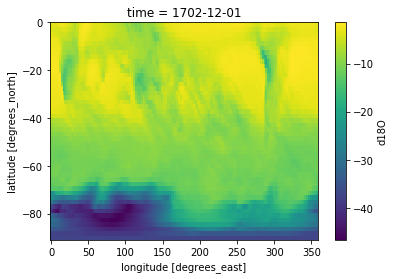

In [27]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
d18O_shem_seas_mean_raw_ctrl = d18O_raw_shem_tmon_ctrl[2:(len(d18O_raw_shem_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
d18O_shem_seas_mean_raw_ctrl[3].plot()

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


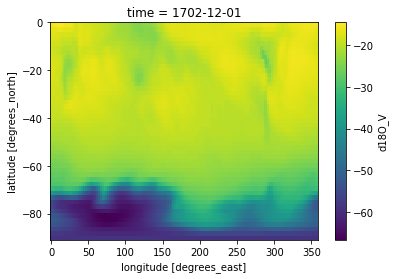

In [28]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
d18O_V_shem_seas_mean_raw_ctrl = d18O_V_raw_shem_tmon_ctrl[2:(len(d18O_V_raw_shem_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
d18O_V_shem_seas_mean_raw_ctrl[3].plot()

<xarray.DataArray 'd18O' (time: 74, lat: 48, lon: 144)>
array([[[-37.520863, -37.52083 , ..., -37.520847, -37.520863],
        [-37.421524, -37.601627, ..., -37.27537 , -37.341854],
        ...,
        [ -3.784319,  -3.912191, ...,  -3.192405,  -3.505965],
        [ -3.362854,  -3.378054, ...,  -2.764603,  -3.111979]],

       [[-37.079357, -37.079357, ..., -37.079357, -37.079334],
        [-37.93051 , -38.080276, ..., -37.684048, -37.794846],
        ...,
        [ -3.944099,  -4.247725, ...,  -3.55802 ,  -3.785749],
        [ -2.836545,  -3.11778 , ...,  -2.53437 ,  -2.650062]],

       ...,

       [[-36.886433, -36.886456, ..., -36.886456, -36.886433],
        [-37.45707 , -37.436802, ..., -37.543873, -37.5043  ],
        ...,
        [ -3.434936,  -3.436744, ...,  -3.228843,  -3.334145],
        [ -3.079891,  -3.298283, ...,  -2.769728,  -2.891242]],

       [[-36.85528 , -36.85528 , ..., -36.85524 , -36.85524 ],
        [-37.965458, -38.081467, ..., -37.790497, -37.86685 ],
    

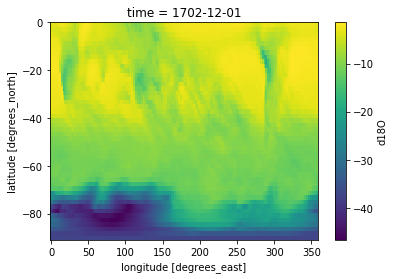

In [29]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_djf(d18O_shem_seas_mean_raw_ctrl['time.month']))
mam_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_mam(d18O_shem_seas_mean_raw_ctrl['time.month']))
jja_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_jja(d18O_shem_seas_mean_raw_ctrl['time.month']))
son_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_son(d18O_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_d18O_shem_seas_mean_raw_ctrl[0].plot()
print(djf_d18O_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

<xarray.DataArray 'd18O_V' (time: 74, lat: 48, lon: 144)>
array([[[-59.08078 , -59.08078 , ..., -59.08078 , -59.08078 ],
        [-57.954136, -58.038147, ..., -57.778362, -57.867443],
        ...,
        [-16.707222, -16.69297 , ..., -16.254946, -16.523031],
        [-15.80914 , -15.748642, ..., -15.67747 , -15.764699]],

       [[-59.952267, -59.952267, ..., -59.95226 , -59.952267],
        [-60.201473, -60.267654, ..., -60.058933, -60.13051 ],
        ...,
        [-17.745   , -18.222795, ..., -17.032103, -17.337862],
        [-16.32455 , -16.48281 , ..., -16.047445, -16.210573]],

       ...,

       [[-61.17972 , -61.179718, ..., -61.179718, -61.179718],
        [-60.585224, -60.611572, ..., -60.520214, -60.556095],
        ...,
        [-16.295687, -16.297987, ..., -16.303656, -16.303577],
        [-15.835309, -15.683846, ..., -15.814769, -15.868114]],

       [[-59.902004, -59.901997, ..., -59.901997, -59.901997],
        [-59.743317, -59.79263 , ..., -59.64208 , -59.69646 ],
  

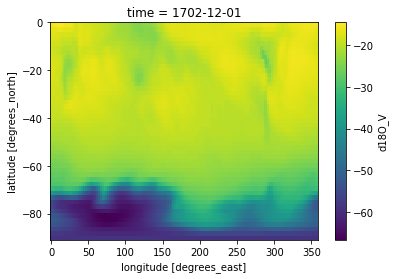

In [30]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_djf(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
mam_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_mam(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
jja_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_jja(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
son_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_son(d18O_V_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_d18O_V_shem_seas_mean_raw_ctrl[0].plot()
print(djf_d18O_V_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [31]:
#Field variable with annual mean

d18O_shem_ann_mean_raw_ctrl = d18O_raw_shem_tmon_ctrl.resample(time='AS').mean(axis=0)
d18O_shem_ann_mean_raw_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'd18O' (time: 75, lat: 48, lon: 144)>
array([[[-44.003117, -44.003098, ..., -44.003128, -44.00313 ],
        [-44.77252 , -44.930065, ..., -44.463455, -44.607807],
        ...,
        [ -3.525322,  -3.636455, ...,  -3.434767,  -3.450766],
        [ -3.732195,  -3.826991, ...,  -3.517951,  -3.568609]],

       [[-40.756897, -40.757042, ..., -40.756794, -40.756866],
        [-42.12756 , -42.212193, ..., -41.924133, -42.028896],
        ...,
        [ -3.554578,  -3.664628, ...,  -3.279567,  -3.424192],
        [ -3.626451,  -3.827145, ...,  -3.34312 ,  -3.405204]],

       ...,

       [[-40.962482, -40.96245 , ..., -40.96229 , -40.962296],
        [-41.683445, -41.849552, ..., -41.33196 , -41.50964 ],
        ...,
        [ -3.850271,  -3.933609, ...,  -3.764133,  -3.803397],
        [ -4.075492,  -4.281804, ...,  -3.885945,  -3.977219]],

       [[-43.039318, -43.039333, ..., -43.039234, -43.03925 ],
        [-44.052418, -44.17267 , ..., -43.79729 , -43.933567],
    

In [32]:
#Field variable with annual mean

d18O_V_shem_ann_mean_raw_ctrl = d18O_V_raw_shem_tmon_ctrl.resample(time='AS').mean(axis=0)
d18O_V_shem_ann_mean_raw_ctrl


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'd18O_V' (time: 75, lat: 48, lon: 144)>
array([[[-66.449745, -66.44975 , ..., -66.44974 , -66.44974 ],
        [-66.660835, -66.75718 , ..., -66.462845, -66.56443 ],
        ...,
        [-17.749075, -17.658186, ..., -17.766771, -17.808914],
        [-17.917349, -17.77449 , ..., -17.986914, -18.000174]],

       [[-64.64318 , -64.64319 , ..., -64.64318 , -64.64318 ],
        [-64.97857 , -65.08544 , ..., -64.75028 , -64.867134],
        ...,
        [-17.632013, -17.71684 , ..., -17.440027, -17.498434],
        [-17.550774, -17.61408 , ..., -17.438223, -17.469675]],

       ...,

       [[-65.6139  , -65.61389 , ..., -65.61389 , -65.61389 ],
        [-66.02416 , -66.13384 , ..., -65.78907 , -65.90913 ],
        ...,
        [-18.130888, -18.025455, ..., -18.242569, -18.251326],
        [-18.265835, -18.20651 , ..., -18.326147, -18.34199 ]],

       [[-65.54482 , -65.54482 , ..., -65.54482 , -65.54482 ],
        [-65.74589 , -65.848274, ..., -65.5335  , -65.64183 ],
  

### Calculate each year's seasonal mean V10 and U10 (not detrending); then select the years associated with Upper and Lower Quartiles of indices (Later)

In [33]:
v10_shem_tmon_ctrl = v10_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

# #No Detrend Southern Hem v10; use of scipy
# #has some missing values, need to fill those with zeros 
# #requires remapping back to xr dataArray 
# #Returns the detrended v10 data 
# #the print lines help determine the shape and number of nans

# aa1 = signal.detrend(v10_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# # print(4, aa1[0,25,11])
# # print(5, aa1[0,25,33])
# # print(6, np.count_nonzero(aa1[0,:,:]))


# aa2 = xr.DataArray(aa1, coords={'time': v10_shem_tmon_ctrl.coords['time'], 'lat': v10_shem_tmon_ctrl.coords['lat'],'lon': v10_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# # print(7, aa2[0,25,11].values)
# # print(8, aa2[0,25,33].values)
# # print(9, np.count_nonzero(aa2[0,:,:]))

v10_shem_tmon_raw_ctrl = v10_shem_tmon_ctrl
# v10_shem_tmon_raw_ctrl


#In case I eventually want the d180 to have climatology removed and normalized, that is done below
#Create v10 Monthly Climatology from detrended data using data from time_lo to time_hi
v10_raw_shem_climatology_ctrl = v10_shem_tmon_raw_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# v10_raw_shem_climatology_ctrl

#Find Southern Hemisphere v10 Anoms using the climatology from time_lo to time_hi
v10_anoms_shem_tmon_raw_ctrl = v10_shem_tmon_raw_ctrl.groupby('time.month') - v10_raw_shem_climatology_ctrl

#Normalize Southern Hemisphere v10 Anoms (from detrended data)
v10_anoms_shem_tmon_raw_norm_ctrl = (v10_anoms_shem_tmon_raw_ctrl - v10_anoms_shem_tmon_raw_ctrl.mean(dim='time'))/v10_anoms_shem_tmon_raw_ctrl.std(dim='time')
# v10_anoms_shem_tmon_raw_norm_ctrl


In [34]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
v10_shem_seas_mean_raw_ctrl = v10_shem_tmon_raw_ctrl[2:(len(v10_shem_tmon_raw_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
# v10_shem_seas_mean_raw_ctrl[3].plot()

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'v10' (time: 74, lat: 48, lon: 144)>
array([[[-5.762455, -5.824053, ..., -5.606487, -5.689886],
        [-3.900912, -4.026025, ..., -3.623086, -3.766363],
        ...,
        [ 2.9617  ,  2.905066, ...,  2.935393,  2.978221],
        [ 2.139477,  2.049727, ...,  2.231902,  2.209917]],

       [[-4.689526, -4.762203, ..., -4.517546, -4.607922],
        [-2.320673, -2.459648, ..., -2.028229, -2.176658],
        ...,
        [ 1.748196,  1.611596, ...,  1.909208,  1.855933],
        [ 0.954286,  0.890357, ...,  1.150775,  1.053668]],

       ...,

       [[-5.244249, -5.293781, ..., -5.11535 , -5.184734],
        [-3.257853, -3.369063, ..., -3.011774, -3.13854 ],
        ...,
        [ 3.049374,  3.095475, ...,  2.970906,  3.030012],
        [ 2.406647,  2.405835, ...,  2.349147,  2.400327]],

       [[-5.74749 , -5.802147, ..., -5.60548 , -5.681894],
        [-3.547612, -3.661591, ..., -3.295805, -3.425479],
        ...,
        [ 3.779226,  3.657283, ...,  3.784882,  

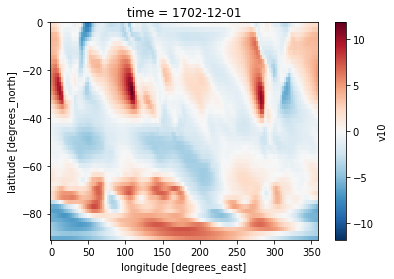

In [35]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_v10_shem_seas_mean_raw_ctrl = v10_shem_seas_mean_raw_ctrl.sel(time=is_djf(v10_shem_seas_mean_raw_ctrl['time.month']))
mam_v10_shem_seas_mean_raw_ctrl = v10_shem_seas_mean_raw_ctrl.sel(time=is_mam(v10_shem_seas_mean_raw_ctrl['time.month']))
jja_v10_shem_seas_mean_raw_ctrl = v10_shem_seas_mean_raw_ctrl.sel(time=is_jja(v10_shem_seas_mean_raw_ctrl['time.month']))
son_v10_shem_seas_mean_raw_ctrl = v10_shem_seas_mean_raw_ctrl.sel(time=is_son(v10_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_v10_shem_seas_mean_raw_ctrl[0].plot()
print(djf_v10_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [36]:
#Field variable with  and annual mean

v10_shem_ann_mean_raw_ctrl = v10_shem_tmon_raw_ctrl.resample(time='AS').mean(axis=0)
#v10_shem_ann_mean_raw_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [37]:
u10_shem_tmon_ctrl = u10_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

# #No Detrend Southern Hem u10; use of scipy
# #has some missing values, need to fill those with zeros 
# #requires remapping back to xr dataArray 
# #Returns the detrended u10 data 
# #the print lines help determine the shape and number of nans

# aa1 = signal.detrend(u10_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# # print(4, aa1[0,25,11])
# # print(5, aa1[0,25,33])
# # print(6, np.count_nonzero(aa1[0,:,:]))


# aa2 = xr.DataArray(aa1, coords={'time': u10_shem_tmon_ctrl.coords['time'], 'lat': u10_shem_tmon_ctrl.coords['lat'],'lon': u10_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# # print(7, aa2[0,25,11].values)
# # print(8, aa2[0,25,33].values)
# # print(9, np.count_nonzero(aa2[0,:,:]))

u10_shem_tmon_raw_ctrl = u10_shem_tmon_ctrl
# u10_shem_tmon_raw_ctrl


#In case I eventually want the d180 to have climatology removed and normalized, that is done below
#Create u10 Monthly Climatology from detrended data using data from time_lo to time_hi
u10_raw_shem_climatology_ctrl = u10_shem_tmon_raw_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# u10_raw_shem_climatology_ctrl

#Find Southern Hemisphere u10 Anoms using the climatology from time_lo to time_hi
u10_anoms_shem_tmon_raw_ctrl = u10_shem_tmon_raw_ctrl.groupby('time.month') - u10_raw_shem_climatology_ctrl

#Normalize Southern Hemisphere u10 Anoms (from detrended data)
u10_anoms_shem_tmon_raw_norm_ctrl = (u10_anoms_shem_tmon_raw_ctrl - u10_anoms_shem_tmon_raw_ctrl.mean(dim='time'))/u10_anoms_shem_tmon_raw_ctrl.std(dim='time')
# u10_anoms_shem_tmon_raw_norm_ctrl


In [38]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
u10_shem_seas_mean_raw_ctrl = u10_shem_tmon_raw_ctrl[2:(len(u10_shem_tmon_raw_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
# u10_shem_seas_mean_raw_ctrl[3].plot()

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'u10' (time: 74, lat: 48, lon: 144)>
array([[[-1.537931, -1.285112, ..., -2.034309, -1.787822],
        [-4.396633, -4.087852, ..., -4.967184, -4.690052],
        ...,
        [-1.213858, -0.714556, ..., -2.395136, -1.790496],
        [-0.391316,  0.127362, ..., -1.580785, -0.983101]],

       [[-1.768498, -1.56226 , ..., -2.170487, -1.971368],
        [-4.838351, -4.576088, ..., -5.31692 , -5.085617],
        ...,
        [-0.229549,  0.12784 , ..., -1.332028, -0.752891],
        [ 0.478242,  0.933346, ..., -0.519321, -0.010982]],

       ...,

       [[-1.249981, -1.020041, ..., -1.702291, -1.477543],
        [-4.313276, -3.997528, ..., -4.899575, -4.614368],
        ...,
        [-1.548292, -0.98431 , ..., -2.642562, -2.10235 ],
        [-0.880436, -0.32406 , ..., -1.839706, -1.380164]],

       [[-1.378445, -1.126431, ..., -1.874126, -1.627835],
        [-4.455373, -4.129905, ..., -5.056472, -4.764614],
        ...,
        [-0.986286, -0.51476 , ..., -2.060981, -

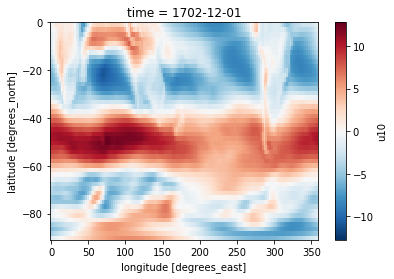

In [39]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_u10_shem_seas_mean_raw_ctrl = u10_shem_seas_mean_raw_ctrl.sel(time=is_djf(u10_shem_seas_mean_raw_ctrl['time.month']))
mam_u10_shem_seas_mean_raw_ctrl = u10_shem_seas_mean_raw_ctrl.sel(time=is_mam(u10_shem_seas_mean_raw_ctrl['time.month']))
jja_u10_shem_seas_mean_raw_ctrl = u10_shem_seas_mean_raw_ctrl.sel(time=is_jja(u10_shem_seas_mean_raw_ctrl['time.month']))
son_u10_shem_seas_mean_raw_ctrl = u10_shem_seas_mean_raw_ctrl.sel(time=is_son(u10_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_u10_shem_seas_mean_raw_ctrl[0].plot()
print(djf_u10_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [40]:
#Field variable with  and annual mean

u10_shem_ann_mean_raw_ctrl = u10_shem_tmon_raw_ctrl.resample(time='AS').mean(axis=0)
#u10_shem_ann_mean_raw_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [41]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA1_djf_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA1_mam_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA1_jja_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_ctrl = pd.DataFrame(data=d)
# PSA1_son_mean_ctrl

d = {'PSA1': SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna()),1)}
PSA1_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA1_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_ctrl
PSA1_djf_mean_upper_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_ctrl

PSA1_mam_mean_lower_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_ctrl
PSA1_mam_mean_upper_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_ctrl

PSA1_jja_mean_lower_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_ctrl
PSA1_jja_mean_upper_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_ctrl

PSA1_son_mean_lower_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_ctrl
PSA1_son_mean_upper_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_ctrl

PSA1_ann_mean_lower_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_ctrl
PSA1_ann_mean_upper_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_ctrl

In [42]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_upper_PSA1_raw_ctrl = djf_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_w_lower_PSA1_raw_ctrl = djf_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_d18O_w_upper_PSA1_raw_ctrl
# djf_d18O_w_lower_PSA1_raw_ctrl

#mam
mam_d18O_w_upper_PSA1_raw_ctrl = mam_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_w_lower_PSA1_raw_ctrl = mam_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_d18O_w_upper_PSA1_raw_ctrl
# mam_d18O_w_lower_PSA1_raw_ctrl

#jja
jja_d18O_w_upper_PSA1_raw_ctrl = jja_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_w_lower_PSA1_raw_ctrl = jja_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_d18O_w_upper_PSA1_raw_ctrl
# jja_d18O_w_lower_PSA1_raw_ctrl

#son
son_d18O_w_upper_PSA1_raw_ctrl = son_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_w_lower_PSA1_raw_ctrl = son_d18O_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_w_upper_PSA1_raw_ctrl
# son_d18O_w_lower_PSA1_raw_ctrl

#ann mean
ann_mean_d18O_w_upper_PSA1_raw_ctrl = d18O_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_w_lower_PSA1_raw_ctrl = d18O_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_d18O_w_upper_PSA1_raw_ctrl
# ann_mean_d18O_w_lower_PSA1_raw_ctrl


In [43]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_V_w_upper_PSA1_raw_ctrl = djf_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_w_lower_PSA1_raw_ctrl = djf_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_d18O_V_w_upper_PSA1_raw_ctrl
# djf_d18O_V_w_lower_PSA1_raw_ctrl

#mam
mam_d18O_V_w_upper_PSA1_raw_ctrl = mam_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_w_lower_PSA1_raw_ctrl = mam_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_d18O_V_w_upper_PSA1_raw_ctrl
# mam_d18O_V_w_lower_PSA1_raw_ctrl

#jja
jja_d18O_V_w_upper_PSA1_raw_ctrl = jja_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_w_lower_PSA1_raw_ctrl = jja_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_d18O_V_w_upper_PSA1_raw_ctrl
# jja_d18O_V_w_lower_PSA1_raw_ctrl

#son
son_d18O_V_w_upper_PSA1_raw_ctrl = son_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_w_lower_PSA1_raw_ctrl = son_d18O_V_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_w_upper_PSA1_raw_ctrl
# son_d18O_V_w_lower_PSA1_raw_ctrl

#ann mean
ann_mean_d18O_V_w_upper_PSA1_raw_ctrl = d18O_V_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_w_lower_PSA1_raw_ctrl = d18O_V_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_d18O_V_w_upper_PSA1_raw_ctrl
# ann_mean_d18O_V_w_lower_PSA1_raw_ctrl


In [44]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl



In [45]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_PSA1_ttest_stats_ctrl, djf_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_upper_PSA1_raw_ctrl, djf_d18O_w_lower_PSA1_raw_ctrl, axis=0)

mam_d18O_change_due_to_PSA1_ttest_stats_ctrl, mam_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_upper_PSA1_raw_ctrl, mam_d18O_w_lower_PSA1_raw_ctrl, axis=0)

jja_d18O_change_due_to_PSA1_ttest_stats_ctrl, jja_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_upper_PSA1_raw_ctrl, jja_d18O_w_lower_PSA1_raw_ctrl, axis=0)

son_d18O_change_due_to_PSA1_ttest_stats_ctrl, son_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_upper_PSA1_raw_ctrl, son_d18O_w_lower_PSA1_raw_ctrl, axis=0)

ann_mean_d18O_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_upper_PSA1_raw_ctrl, ann_mean_d18O_w_lower_PSA1_raw_ctrl, axis=0)

In [46]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_V_change_due_to_PSA1_ttest_stats_ctrl, djf_d18O_V_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_V_w_upper_PSA1_raw_ctrl, djf_d18O_V_w_lower_PSA1_raw_ctrl, axis=0)

mam_d18O_V_change_due_to_PSA1_ttest_stats_ctrl, mam_d18O_V_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_V_w_upper_PSA1_raw_ctrl, mam_d18O_V_w_lower_PSA1_raw_ctrl, axis=0)

jja_d18O_V_change_due_to_PSA1_ttest_stats_ctrl, jja_d18O_V_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_V_w_upper_PSA1_raw_ctrl, jja_d18O_V_w_lower_PSA1_raw_ctrl, axis=0)

son_d18O_V_change_due_to_PSA1_ttest_stats_ctrl, son_d18O_V_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_d18O_V_w_upper_PSA1_raw_ctrl, son_d18O_V_w_lower_PSA1_raw_ctrl, axis=0)

ann_mean_d18O_V_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_d18O_V_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_V_w_upper_PSA1_raw_ctrl, ann_mean_d18O_V_w_lower_PSA1_raw_ctrl, axis=0)

In [47]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_v10_w_upper_PSA1_raw_ctrl = djf_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_v10_w_lower_PSA1_raw_ctrl = djf_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_v10_w_upper_PSA1_raw_ctrl
# djf_v10_w_lower_PSA1_raw_ctrl

#mam
mam_v10_w_upper_PSA1_raw_ctrl = mam_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_v10_w_lower_PSA1_raw_ctrl = mam_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_v10_w_upper_PSA1_raw_ctrl
# mam_v10_w_lower_PSA1_raw_ctrl

#jja
jja_v10_w_upper_PSA1_raw_ctrl = jja_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_v10_w_lower_PSA1_raw_ctrl = jja_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_v10_w_upper_PSA1_raw_ctrl
# jja_v10_w_lower_PSA1_raw_ctrl

#son
son_v10_w_upper_PSA1_raw_ctrl = son_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_v10_w_lower_PSA1_raw_ctrl = son_v10_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_v10_w_upper_PSA1_raw_ctrl
# son_v10_w_lower_PSA1_raw_ctrl

#ann mean
ann_mean_v10_w_upper_PSA1_raw_ctrl = v10_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_v10_w_lower_PSA1_raw_ctrl = v10_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_v10_w_upper_PSA1_raw_ctrl
# ann_mean_v10_w_lower_PSA1_raw_ctrl


In [48]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_u10_w_upper_PSA1_raw_ctrl = djf_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_u10_w_lower_PSA1_raw_ctrl = djf_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_u10_w_upper_PSA1_raw_ctrl
# djf_u10_w_lower_PSA1_raw_ctrl

#mam
mam_u10_w_upper_PSA1_raw_ctrl = mam_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_u10_w_lower_PSA1_raw_ctrl = mam_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_u10_w_upper_PSA1_raw_ctrl
# mam_u10_w_lower_PSA1_raw_ctrl

#jja
jja_u10_w_upper_PSA1_raw_ctrl = jja_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_u10_w_lower_PSA1_raw_ctrl = jja_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_u10_w_upper_PSA1_raw_ctrl
# jja_u10_w_lower_PSA1_raw_ctrl

#son
son_u10_w_upper_PSA1_raw_ctrl = son_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_u10_w_lower_PSA1_raw_ctrl = son_u10_shem_seas_mean_raw_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_u10_w_upper_PSA1_raw_ctrl
# son_u10_w_lower_PSA1_raw_ctrl

#ann mean
ann_mean_u10_w_upper_PSA1_raw_ctrl = u10_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_u10_w_lower_PSA1_raw_ctrl = u10_shem_ann_mean_raw_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_u10_w_upper_PSA1_raw_ctrl
# ann_mean_u10_w_lower_PSA1_raw_ctrl


In [49]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_v10_change_due_to_PSA1_ttest_stats_ctrl, djf_v10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_v10_w_upper_PSA1_raw_ctrl, djf_v10_w_lower_PSA1_raw_ctrl, axis=0)

mam_v10_change_due_to_PSA1_ttest_stats_ctrl, mam_v10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_v10_w_upper_PSA1_raw_ctrl, mam_v10_w_lower_PSA1_raw_ctrl, axis=0)

jja_v10_change_due_to_PSA1_ttest_stats_ctrl, jja_v10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_v10_w_upper_PSA1_raw_ctrl, jja_v10_w_lower_PSA1_raw_ctrl, axis=0)

son_v10_change_due_to_PSA1_ttest_stats_ctrl, son_v10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_v10_w_upper_PSA1_raw_ctrl, son_v10_w_lower_PSA1_raw_ctrl, axis=0)

ann_mean_v10_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_v10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_v10_w_upper_PSA1_raw_ctrl, ann_mean_v10_w_lower_PSA1_raw_ctrl, axis=0)

In [50]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_u10_change_due_to_PSA1_ttest_stats_ctrl, djf_u10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_u10_w_upper_PSA1_raw_ctrl, djf_u10_w_lower_PSA1_raw_ctrl, axis=0)

mam_u10_change_due_to_PSA1_ttest_stats_ctrl, mam_u10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_u10_w_upper_PSA1_raw_ctrl, mam_u10_w_lower_PSA1_raw_ctrl, axis=0)

jja_u10_change_due_to_PSA1_ttest_stats_ctrl, jja_u10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_u10_w_upper_PSA1_raw_ctrl, jja_u10_w_lower_PSA1_raw_ctrl, axis=0)

son_u10_change_due_to_PSA1_ttest_stats_ctrl, son_u10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_u10_w_upper_PSA1_raw_ctrl, son_u10_w_lower_PSA1_raw_ctrl, axis=0)

ann_mean_u10_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_u10_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_u10_w_upper_PSA1_raw_ctrl, ann_mean_u10_w_lower_PSA1_raw_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region (d18O weighted, d18O unweighted, d18O water vapor) as well as the total d18O contributions at WDC
### Data is Raw - ie, the seasonal mean has not been removed nor was the original data detrended

In [51]:
#Select d18O weighted raw for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = son_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = son_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = son_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = son_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)


#other lats
djf_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = djf_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = djf_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)

mam_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = mam_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = mam_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)

jja_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = jja_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = jja_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)

son_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = son_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = son_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)

ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)

In [52]:
#Select d18O unweighted raw for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)

#other lats
djf_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = djf_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)

mam_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = mam_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)

jja_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = jja_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)

son_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = son_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = son_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)

ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = ann_mean_d18O_unweighted_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)


In [53]:
#Select d18O water vapor raw for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_V_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = djf_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = djf_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = djf_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = djf_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = mam_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = mam_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = mam_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = mam_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = jja_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = jja_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = jja_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = jja_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = son_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = son_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = son_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = son_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_05_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_15_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_25_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_AA_land_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_AA_land_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)

#other lats
djf_d18O_V_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = djf_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = djf_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = djf_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = djf_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_V_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = djf_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_V_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = djf_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)

mam_d18O_V_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = mam_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = mam_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = mam_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = mam_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_V_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = mam_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_V_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = mam_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)

jja_d18O_V_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = jja_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = jja_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = jja_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = jja_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_V_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = jja_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_V_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = jja_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)

son_d18O_V_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = son_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = son_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = son_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = son_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_V_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = son_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_V_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = son_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)

ann_mean_d18O_V_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Atl_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Pac_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_35_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_45_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_55_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_65_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_V_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl = ann_mean_d18O_V_raw_Ind_75_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)

In [54]:
print('pseudoWDC DJF PSA1 Upper =',np.round(djf_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Lower =',np.round(djf_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Diff =',np.round(djf_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice DJF PSA1 Upper =',np.round(djf_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Lower =',np.round(djf_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Diff =',np.round(djf_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))

print('pseudoWDC MAM PSA1 Upper =',np.round(mam_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Lower =',np.round(mam_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Diff =',np.round(mam_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice MAM PSA1 Upper =',np.round(mam_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Lower =',np.round(mam_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Diff =',np.round(mam_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
      

print('pseudoWDC JJA PSA1 Upper =',np.round(jja_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Lower =',np.round(jja_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Diff =',np.round(jja_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice JJA PSA1 Upper =',np.round(jja_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Lower =',np.round(jja_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Diff =',np.round(jja_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))


print('pseudoWDC SON PSA1 Upper =',np.round(son_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Lower =',np.round(son_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Diff =',np.round(son_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice SON PSA1 Upper =',np.round(son_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Lower =',np.round(son_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Diff =',np.round(son_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))


print('pseudoWDC Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))



pseudoWDC DJF PSA1 Upper = -20.89 , pseudoWDC DJF PSA1 Lower = -20.59 , pseudoWDC DJF PSA1 Diff = -0.3
Atl 05 DJF PSA1 Upper = -0.05 , Atl 05 DJF PSA1 Lower = -0.04 , Atl 05 DJF PSA1 Diff = -0.01
Atl 15 DJF PSA1 Upper = -0.23 , Atl 15 DJF PSA1 Lower = -0.22 , Atl 15 DJF PSA1 Diff = -0.01
Atl 25 DJF PSA1 Upper = -0.41 , Atl 25 DJF PSA1 Lower = -0.37 , Atl 25 DJF PSA1 Diff = -0.03
Atl 35 DJF PSA1 Upper = -0.6 , Atl 35 DJF PSA1 Lower = -0.56 , Atl 35 DJF PSA1 Diff = -0.04
Atl 45 DJF PSA1 Upper = -0.72 , Atl 45 DJF PSA1 Lower = -0.66 , Atl 45 DJF PSA1 Diff = -0.06
Atl 55 DJF PSA1 Upper = -0.38 , Atl 55 DJF PSA1 Lower = -0.4 , Atl 55 DJF PSA1 Diff = 0.02
Atl 65 DJF PSA1 Upper = -0.17 , Atl 65 DJF PSA1 Lower = -0.2 , Atl 65 DJF PSA1 Diff = 0.03
Atl 75 DJF PSA1 Upper = -0.07 , Atl 75 DJF PSA1 Lower = -0.1 , Atl 75 DJF PSA1 Diff = 0.03
Pac 05 DJF PSA1 Upper = -0.2 , Pac 05 DJF PSA1 Lower = -0.2 , Pac 05 DJF PSA1 Diff = -0.0
Pac 15 DJF PSA1 Upper = -0.58 , Pac 15 DJF PSA1 Lower = -0.59 , Pac 15

In [55]:
print('pseudoWDC DJF PSA1 Upper =',np.round(djf_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Lower =',np.round(djf_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Diff =',np.round(djf_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice DJF PSA1 Upper =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Lower =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Diff =',np.round(djf_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))

print('pseudoWDC MAM PSA1 Upper =',np.round(mam_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Lower =',np.round(mam_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Diff =',np.round(mam_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice MAM PSA1 Upper =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Lower =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Diff =',np.round(mam_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
      

print('pseudoWDC JJA PSA1 Upper =',np.round(jja_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Lower =',np.round(jja_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Diff =',np.round(jja_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice JJA PSA1 Upper =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Lower =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Diff =',np.round(jja_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))


print('pseudoWDC SON PSA1 Upper =',np.round(son_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Lower =',np.round(son_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Diff =',np.round(son_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice SON PSA1 Upper =',np.round(son_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Lower =',np.round(son_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Diff =',np.round(son_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))


print('pseudoWDC Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_w_upper_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_lower_PSA1_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Atl_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Pac_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 05 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 05 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_05_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 15 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 15 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_15_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 25 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 25 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_25_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 35 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 35 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_35_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 45 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 45 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_45_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 55 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 55 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_55_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 65 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 65 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_65_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 75 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 75 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_Ind_75_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_unweighted_raw_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))



pseudoWDC DJF PSA1 Upper = -20.89 , pseudoWDC DJF PSA1 Lower = -20.59 , pseudoWDC DJF PSA1 Diff = -0.3
Atl 05 DJF PSA1 Upper = -55.12 , Atl 05 DJF PSA1 Lower = -57.03 , Atl 05 DJF PSA1 Diff = 1.91
Atl 15 DJF PSA1 Upper = -42.89 , Atl 15 DJF PSA1 Lower = -43.75 , Atl 15 DJF PSA1 Diff = 0.86
Atl 25 DJF PSA1 Upper = -36.7 , Atl 25 DJF PSA1 Lower = -38.03 , Atl 25 DJF PSA1 Diff = 1.32
Atl 35 DJF PSA1 Upper = -34.11 , Atl 35 DJF PSA1 Lower = -35.42 , Atl 35 DJF PSA1 Diff = 1.31
Atl 45 DJF PSA1 Upper = -32.41 , Atl 45 DJF PSA1 Lower = -32.36 , Atl 45 DJF PSA1 Diff = -0.04
Atl 55 DJF PSA1 Upper = -27.45 , Atl 55 DJF PSA1 Lower = -22.08 , Atl 55 DJF PSA1 Diff = -5.37
Atl 65 DJF PSA1 Upper = -21.56 , Atl 65 DJF PSA1 Lower = -16.12 , Atl 65 DJF PSA1 Diff = -5.44
Atl 75 DJF PSA1 Upper = -21.18 , Atl 75 DJF PSA1 Lower = -15.47 , Atl 75 DJF PSA1 Diff = -5.71
Pac 05 DJF PSA1 Upper = -49.6 , Pac 05 DJF PSA1 Lower = -47.34 , Pac 05 DJF PSA1 Diff = -2.27
Pac 15 DJF PSA1 Upper = -41.59 , Pac 15 DJF PSA1